<a href="https://colab.research.google.com/github/MicMiao/notebooks/blob/main/COVID_19_Impact_on_Digital_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## COVID-19 Impact on Digital Learning

<img src="https://images.unsplash.com/photo-1597933471507-1ca5765185d8?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=751&q=80" style="width:400px;"/>

This is a notebook for the competition launched on Kaggle (https://www.kaggle.com/c/learnplatform-covid19-impact-on-digital-learning).

With the dataset at our disposal and other source of information. We will try to **uncover trends in digital learning** and how such trend relates to factors like district demographics, socio-economic conditions etc.

In particular, we will try to answer the following questions:

    - What is the picture of digital learning in 2020 for the school districts and the States included in the dataset? 
    - How was the students' engagement with different types of technology products over the course of the year? 
    - How does student engagement with online learning platforms relate to different geography? Or to different socio economic conditions? 



In [1]:
#@title Datasets from Kaggle can be downloaded using the opendatsets
!pip install opendatasets --upgrade --quiet

import opendatasets as od

While downloading the dataset, you will be asked to provide your Kaggle username and credentails, which you can obtain using the "Create New API Token" button on your account page on Kaggle. Upload the `kaggle.json` notebook using the files tab or enter the username and key manually when prompted.

In [2]:
#@title Download the datasets
od.download('https://www.kaggle.com/c/learnplatform-covid19-impact-on-digital-learning/data')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mikedoi
Your Kaggle Key: ··········


100%|██████████| 124M/124M [00:01<00:00, 123MB/s]



Extracting archive ./learnplatform-covid19-impact-on-digital-learning/learnplatform-covid19-impact-on-digital-learning.zip to ./learnplatform-covid19-impact-on-digital-learning


In [1]:
#@title Import the necessary libraries
import os
import pandas as pd
import numpy as np
import math
import glob
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pal = sns.color_palette()
import missingno as msno


## Load engagement data into DataFrame

### Engagement data
> The engagement data are aggregated at school district level, and each file in the folder ```engagement_data``` represents data from **one school district***. 

📝The 4-digit file name represents ```district_id``` which can be used to link to district information in ```district_info.csv```. 

📝The ```lp_id``` can be used to link to product information in ```product_info.csv```.

| Name             | Description                                                                                                    |
|------------------|----------------------------------------------------------------------------------------------------------------|
| time             | date in "YYYY-MM-DD"                                                                                           |
| lp_id            | The unique identifier of the product                                                                           |
| pct_access       | Percentage of students in the district have at least one page-load event of a given product and on a given day |
| engagement_index | Total page-load events per one thousand students of a given product and on a given day                         |
| district_id | The unique identifier of the school district   (Custom added from filenames)                     


Here we load all the csv files into an unique DataFrame. And using the filename as the column 'district_id', we'll need this column to merge with the 'District Info DataFrame' later on. 

In [3]:
#@title Load engagement data:
path = '/content/learnplatform-covid19-impact-on-digital-learning/engagement_data'
all_files = glob.glob(path + "/*.csv")

data = [] # pd.concat takes a list of dataframes as an argument
for csv in all_files:
  # read the csv file
  frame = pd.read_csv(csv)
  # split filename and extension
  filename = os.path.splitext(csv)
  # extract district ID from CSV filename tuple
  frame['district_id'] = os.path.basename(filename[0])
  # add new column to new list
  data.append(frame)

engagement_df = pd.concat(data)
engagement_df

,time,lp_id,pct_access,engagement_index,district_id
0,2020-01-01,29322.0,0.00,NaN,4183
1,2020-01-01,76214.0,0.01,0.27,4183
2,2020-01-01,86059.0,0.00,NaN,4183
3,2020-01-01,24829.0,0.02,0.89,4183
4,2020-01-01,41675.0,0.00,NaN,4183
...,...,...,...,...,...
56499,2020-12-31,26488.0,0.12,27.17,4165
56500,2020-12-31,95253.0,0.32,250.23,4165
56501,2020-12-31,37017.0,0.02,0.15,4165
56502,2020-12-31,98265.0,0.05,12.31,4165


In [ ]:
engagement_df.info()

Check for any missing values:

In [ ]:
engagement_df.isnull().sum()

For both 'pct_access' and 'engagement_index' we can fill the NaN with zero. As for 'lp_id' we can either delete these 541 rows or fill them also with zero, we choose the later.

In [4]:
engagement_df.fillna(0, inplace=True)

In [5]:
# convert district_id from object type to numeric type
engagement_df['district_id'] = pd.to_numeric(engagement_df['district_id'])

We have also a 'time' column. For now we don't transform it, we'll consider to do it later if necessary.

In [ ]:
# def split_date(df):
#   df['time'] = pd.to_datetime(df['time'])
#   df['Month'] = df.time.dt.month
#   df['Day'] = df.time.dt.day
#   df['DayOfWeek'] = df.time.dt.dayofweek
#   df['WeekOfYear'] = df.time.dt.isocalendar().week
#   df['DayOfYear'] = df.time.dt.dayofyear

In [ ]:
# split_date(engagement_df)

## Load districts_info data into DataFrame & some EDA

### District information data

>The district file ```districts_info.csv``` includes information about the **characteristics of school districts**, including data from 
>- NCES (2018-19), 
>- FCC (Dec 2018), and 
>- Edunomics Lab. 

Steps taken to preserve Privacy 🔒 
- Identifiable information about the school districts has been removed. 
- An open source tool ARX (Prasser et al. 2020) was used to transform several data fields and reduce the risks of re-identification. 

📝 For data generalization purposes some data points are released with a range where the actual value falls under. Additionally, there are many missing data marked as 'NaN' indicating that the data was suppressed to maximize anonymization of the dataset.

| Name                   | Description                                                                                                                                                                                                                                                                              |
|------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| district_id            | The unique identifier of the school district                                                                                                                                                                                                                                             |
| state                  | The state where the district resides in                                                                                                                                                                                                                                                  |
| locale                 | NCES locale classification that categorizes U.S. territory into four types of areas: City, Suburban, Town, and Rural. See Locale Boundaries User's Manual for more information.                                                                                                          |
| pct_black/hispanic     | Percentage of students in the districts identified as Black or Hispanic based on 2018-19 NCES data                                                                                                                                                                                       |
| pct_free/reduced       | Percentage of students in the districts eligible for free or reduced-price lunch based on 2018-19 NCES data                                                                                                                                                                              |
| county_connections_ratio | ratio (residential fixed high-speed connections over 200 kbps in at least one direction/households) based on the county level data from FCC From 477 (December 2018 version). See FCC data for more information.                                                                         |
| pp_total_raw             | Per-pupil total expenditure (sum of local and federal expenditure) from Edunomics Lab's National Education Resource Database on Schools (NERD$) project. The expenditure data are school-by-school, and we use the median value to represent the expenditure of a given school district. |
                                                         

In [6]:
districts_df = pd.read_csv('/content/learnplatform-covid19-impact-on-digital-learning/districts_info.csv')
districts_df 

,district_id,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw
0,8815,Illinois,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[14000, 16000["
1,2685,NaN,NaN,NaN,NaN,NaN,NaN
2,4921,Utah,Suburb,"[0, 0.2[","[0.2, 0.4[","[0.18, 1[","[6000, 8000["
3,3188,NaN,NaN,NaN,NaN,NaN,NaN
4,2238,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
228,9515,New York,Rural,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[","[18000, 20000["
229,8103,Tennessee,Rural,"[0.2, 0.4[",NaN,"[0.18, 1[","[8000, 10000["
230,4929,Virginia,Rural,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[","[12000, 14000["
231,7975,California,City,"[0.6, 0.8[","[0.6, 0.8[","[0.18, 1[",NaN


In [ ]:
districts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   district_id               233 non-null    int64 
 1   state                     233 non-null    object
 2   locale                    233 non-null    object
 3   pct_black/hispanic        233 non-null    object
 4   pct_free/reduced          233 non-null    object
 5   county_connections_ratio  233 non-null    object
 6   pp_total_raw              233 non-null    object
dtypes: int64(1), object(6)
memory usage: 12.9+ KB


We have a total of **233** school districts. We have also some missing values, later on we'll fill with a string value 'Not disclosed' if neccessary.

### No. of school districts per State:

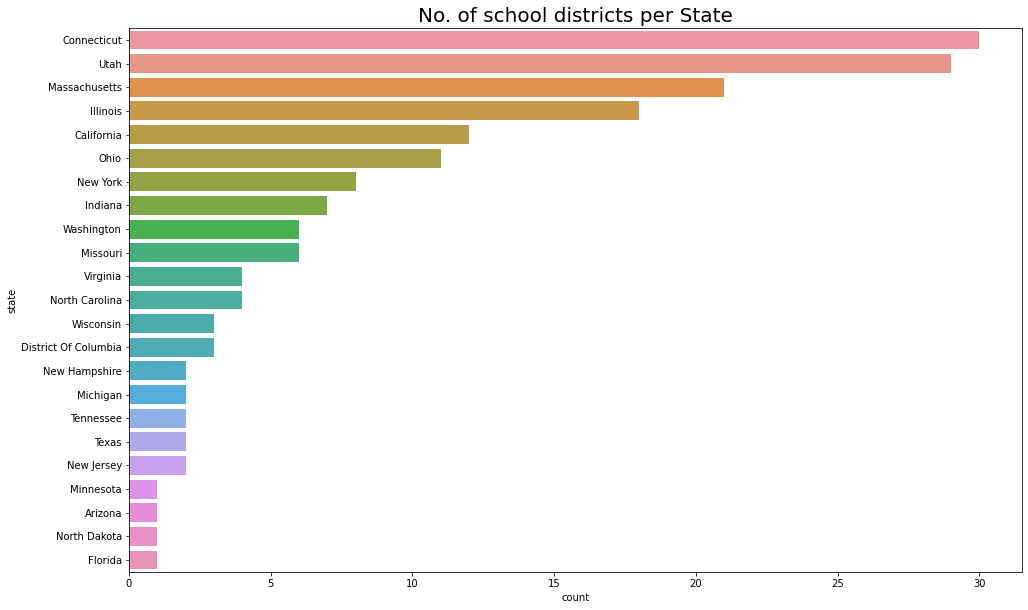

In [ ]:
plt.figure(figsize=(16,10))
plt.title('No. of school districts per State', size=20)
sns.countplot(y='state', data=districts_df, order=districts_df.state.value_counts(ascending=False).index)
plt.show();

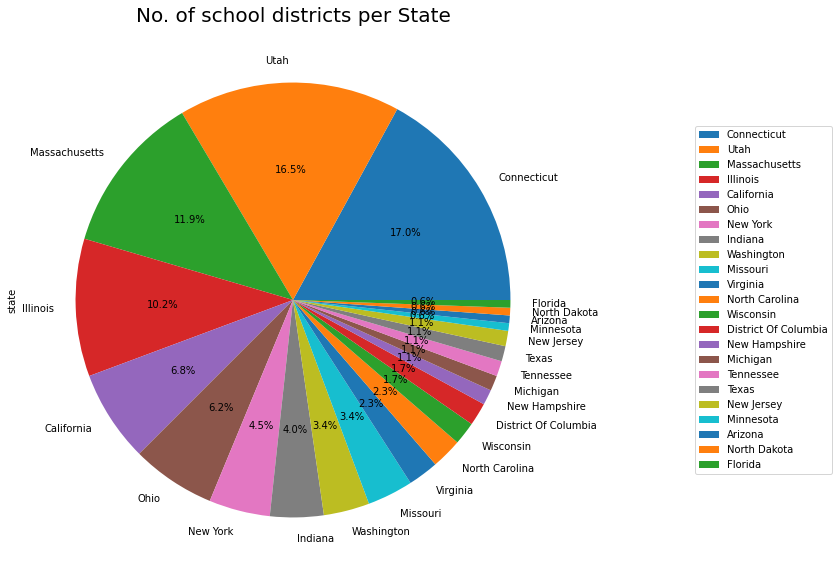

In [ ]:
plt.title('No. of school districts per State', size=20)
districts_df['state'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(16,10), startangle=0).legend(loc='right', bbox_to_anchor=(1.5, 0.5));

We have not a uniform dataset here. There are State with a lot of school districts like Connecticut and Utah and States that have very small samples like: Arizona, Florida, North Dakota, Minnesota. We have to pay attention when we compare the engagement average values for different States, as the number might be not representative if the sample size difference is too big.

We have 55.6% of the school districts coming from just 4 States: Connecticut, Utah, Masschusetts, Illinois.

In [ ]:
print(engagement_df.district_id.nunique())
print(districts_df.district_id.nunique())

233
233


In [ ]:
dlist = districts_df.district_id.unique().tolist()
edlist = engagement_df.district_id.unique().tolist()

for x in dlist:
  if str(x) in edlist:
    continue
  else:
    print(x)

We have checked all 233 distric_id are the same for both dataframes: engagement_df and districts_df.

### Locale Distribution Chart:

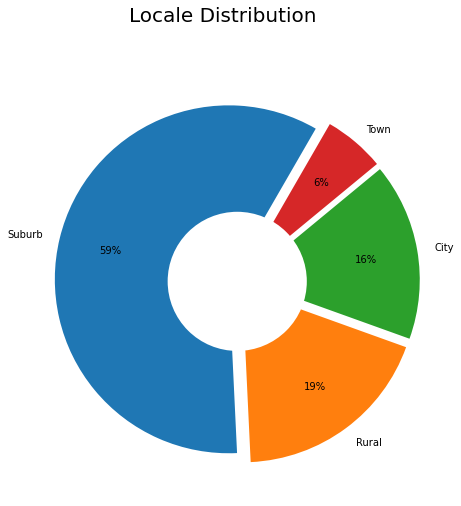

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
fig.suptitle('Locale Distribution', size=20)
explode = (0.05, 0.05, 0.05, 0.05)
labels = list(districts_df.locale.value_counts().index)
sizes = districts_df.locale.value_counts().values
ax.pie(sizes, explode=explode, startangle=60, labels=labels, autopct='%1.0f%%', pctdistance=0.7)
ax.add_artist(plt.Circle((0,0), 0.4, fc='white'))
plt.show()


Also for Locale we don't have a uniform or close to uniform distribution. Our data is heavily skewed towards Suburb and Rural.

### Distribution pct_black/hispanic 

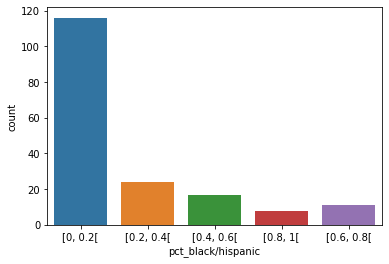

In [ ]:
sns.countplot(data=districts_df, x='pct_black/hispanic')
plt.show()

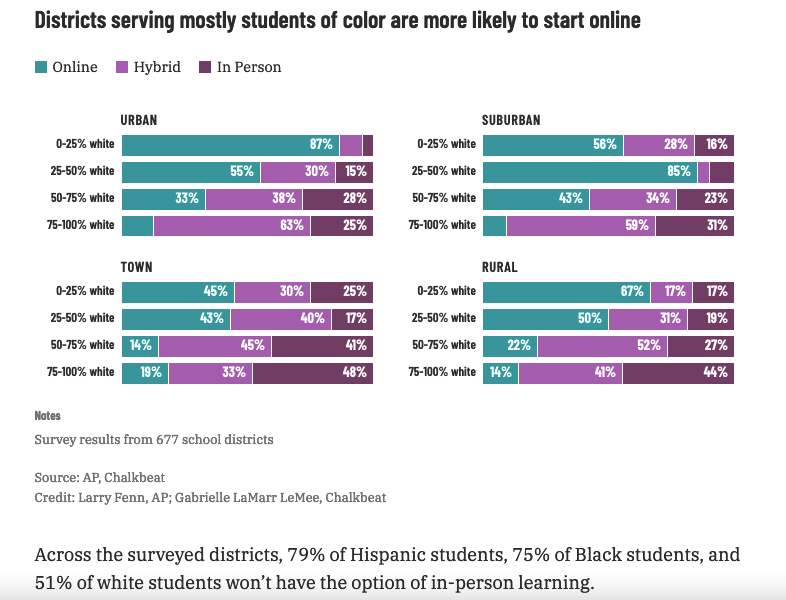

In [ ]:
from IPython.display import Image
Image('/content/learnplatform-covid19-impact-on-digital-learning/Chalkbeat.png')

There is an interesting survey conducted by AP and Chalkbeat in 2020 from 677 school districs covering 13 million students. The main takeaway is that race is a strong predictor of which public schools are offering in-person instruction and which aren't. 

We will try to seek confirmation of such findings also from our dataset.

### Distribution pct_free/reduced

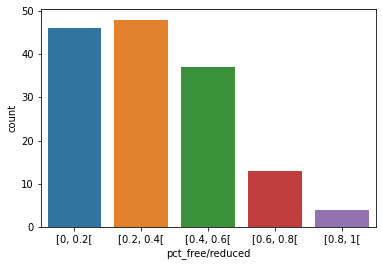

In [ ]:
sns.countplot(data=districts_df, x='pct_free/reduced')
plt.show()

In [ ]:
#@title High speed connection data
districts_df.county_connections_ratio.value_counts()

For this data we'll ignore it right now. We will have better data to address this feature. 

### Per-pupil total expenditure data:

In [ ]:
custom_sort = np.array(['[4000, 6000[','[6000, 8000[', '[8000, 10000[', '[10000, 12000[' ,'[12000, 14000[', '[14000, 16000[', '[16000, 18000[', '[18000, 20000[', '[20000, 22000[', '[22000, 24000[', '[32000, 34000['])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



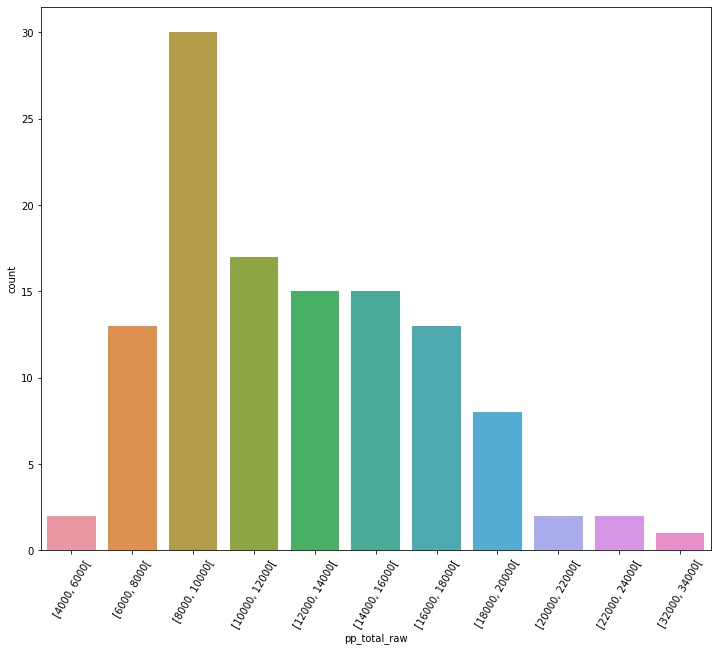

In [ ]:
plt.figure(figsize=(12,10))
sns.countplot(districts_df.pp_total_raw, order=custom_sort)
plt.xticks(rotation=60);

The majority of spending per pupil is concentrated between 6K to 18K. 


## The overall take away from analyzing districts data is that:
- Majority of the school districs in the dataset coming from only 4 States, therefore we have an unbalanced dataset;
- School districts in the dataset mainly are in suburb and rural locales;
- Majority of the school districs (~120 over 176) in the dataset have a lower percentage of both Black and Hispanic students 0-20% compared to the national average (31-40% based on data from National Center for Education Statistics link: https://nces.ed.gov/programs/coe/indicator/cge#fn4).

Therefore we have to be careful to draw conclusion on whatever insights we will find from this dataset. As it represents only the school districts covered by this LearnPlatform dataset, while the country/national picture might differ significantly from it.

# Analysis of digitial learning metrics for school districts and States

Now that we have some idea about our dataset. We proceed with our first series of analysis. In particular, here we would like to investigate our two performance metrics trend among all the available school districts: 
- **pct_access**: Percentage of students in the district have at least one page-load event of a given product and on a given day. 
- **engagement_inde**x: Total page-load events per one thousand students of a given product and on a given day.

## Q1: How was the students' engagement during 2020 in each of our districts?

we'll use the following metrics as proxies:
- **pct_access.max()**: Why max value you may ask. The reason is there are a lot of available products for the students each day. And if we take the mean, we'll underestimate the engagement level. 

>> For example: on Jan. 1st 2020, for the school district 1000 we have 138 different products, each with its pct_access. If we take the mean, which is only 0.145%! Which is obviously wrong, because if we have 5% of students active on only one product, then this 5% should be the reliable estimate for engagement for that day, we can't average it out. In this case the max value is 3.6% on a 'certain' product. We don't care which product at this stage, we just know that 3.6% of the students were active on some technology product that day.

- **engagement_index.sum()**: for engagement_index we choose the sum, as in this way we can have an idea about the total page-load events per one thousand students for all products on a given day for all our school districts.

In [9]:
#@title Calculate Max pct_access value for each district
# engagement_df[(engagement_df['district_id']==1000) & (engagement_df['time']=='2020-01-01')].pct_access.max()

# For each district and each day, we take the maximum pct_access value registered on all available products:
dist_engage_max_pct_access = engagement_df.groupby(['district_id', 'time']).pct_access.max()

# max pct_access for the district no. 1000
# dist_engage_max_pct_access.loc[1000]

# max pct_access for the district no. 1000, on Jan. 1st
# dist_engage_max_pct_access.loc[1000, '2020-01-01']

# max pct_access for all the districts on Jan. 1st
# dist_engage_max_pct_access.loc[:, '2020-01-01']

# max pct_access for each district during 2020:
# it's a df
# dist_engage_max_pct_access_df = dist_engage_max_pct_access.unstack()
# dist_engage_max_pct_access_df

# dist_engage_max_pct_access_df.loc[1000]
# dist_engage_max_pct_access_df.loc[1000, '2020-01-01']
# dist_engage_max_pct_access_df.loc[:, '2020-01-01']

# This also works:
# engagement_df.pivot_table(values='pct_access', index='district_id', columns='time', aggfunc='max')

In [10]:
#@title Calculate cumulative engagement_index for each district
# For the engagement_index we choose to sum all the values up to get a total number
dist_engagement_index_sum = engagement_df.groupby(['district_id', 'time']).engagement_index.sum()


In [11]:
#@title Create an unique DataFrame for both pct_access and engagement_index
dist_pct_access_engagement_df = pd.concat([dist_engage_max_pct_access, dist_engagement_index_sum], axis=1)
dist_pct_access_engagement_df.columns = ['pct_access_max', 'engagement_index_sum']
dist_pct_access_engagement_df

pct_access_max  engagement_index_sum
district_id time                                            
1000        2020-01-01            3.60               3039.34
            2020-01-02           41.76              30226.31
            2020-01-03           49.76              37013.32
            2020-01-04            2.37               1303.03
            2020-01-05            4.76               2448.28
...                                ...                   ...
9927        2020-12-27            2.54               2123.42
            2020-12-28            2.68               2820.85
            2020-12-29            2.66               3075.91
            2020-12-30            2.56               3182.58
            2020-12-31            2.44               3132.87

[79783 rows x 2 columns]

In [12]:
#@title Remove districts with missing data

# pct_access
# dist_engage_max_pct_access_df = dist_engage_max_pct_access.unstack()
# to_be_removed = list(dist_engage_max_pct_access_df.isnull().sum(axis=1).sort_values(ascending=False).head(18).index)

# engagement_index
dist_engagement_index_sum_df = dist_engagement_index_sum.unstack()
to_be_removed = list(dist_engagement_index_sum_df.isnull().sum(axis=1).sort_values(ascending=False).head(18).index)

# Since they both yield the same list of districts, we can use either one:
for index_num in to_be_removed:
  dist_pct_access_engagement_df.drop(index_num, inplace=True)

We have an substantial number of districts which have a lot of missing in both pct_access and engagement_index data. 

For our analysis, we decide to drop all districts with more than 100 days of missing pct_access and engagement_index data (18 of 233 in this case).

In [ ]:
#@title Some manuale serach and check code:

dist_pct_access_engagement_df.loc[(1000),('pct_access_max', 'engagement_index_sum')]

# .loc[(what rows do I want), (what columns do I want)]
# dist_pct_access_engagement_df.loc[(1000, '2020-01-01'), :]
dist_pct_access_engagement_df.loc[(1000, '2020-01-01'), ('pct_access_max')]

dist_pct_access_engagement_df.loc[([1000, 9927], '2020-01-01'), :]

dist_pct_access_engagement_df.loc[(1000, ['2020-01-01', '2020-01-02']), :]

dist_pct_access_engagement_df.loc[(slice(None), ['2020-01-01', '2020-01-02']), :]


In [ ]:
#@title Let's define a general function to plot both pct_access and engagement_index for each district we choose:

def district_metrics(district_num):
  # All the engagement data for the selected district, rolling 7 days to smooth out the effect of weekend:
  district_df = dist_pct_access_engagement_df.loc[[str(district_num)]].rolling(7, min_periods=1).mean()

  # Create a series of dates for x values:
  dates = pd.date_range("1 1 2020", periods=366, freq="D")

  # Create chart:
  fig, axs = plt.subplots(2, 1, figsize=(16,16), sharex=True)

  # Ploting pct_access:
  axs[0].set_title('School district no. ' + str(district_num) + ' daily pct_access maximum values during 2020', size=16)
  axs[0].plot(dates, district_df['pct_access_max'])

  # Ploting engagement_index:
  axs[1].set_title('School district no. ' + str(district_num) + ' daily engagement_index sum values during 2020', size=16)
  axs[1].plot(dates, district_df['engagement_index_sum'])
  plt.show();

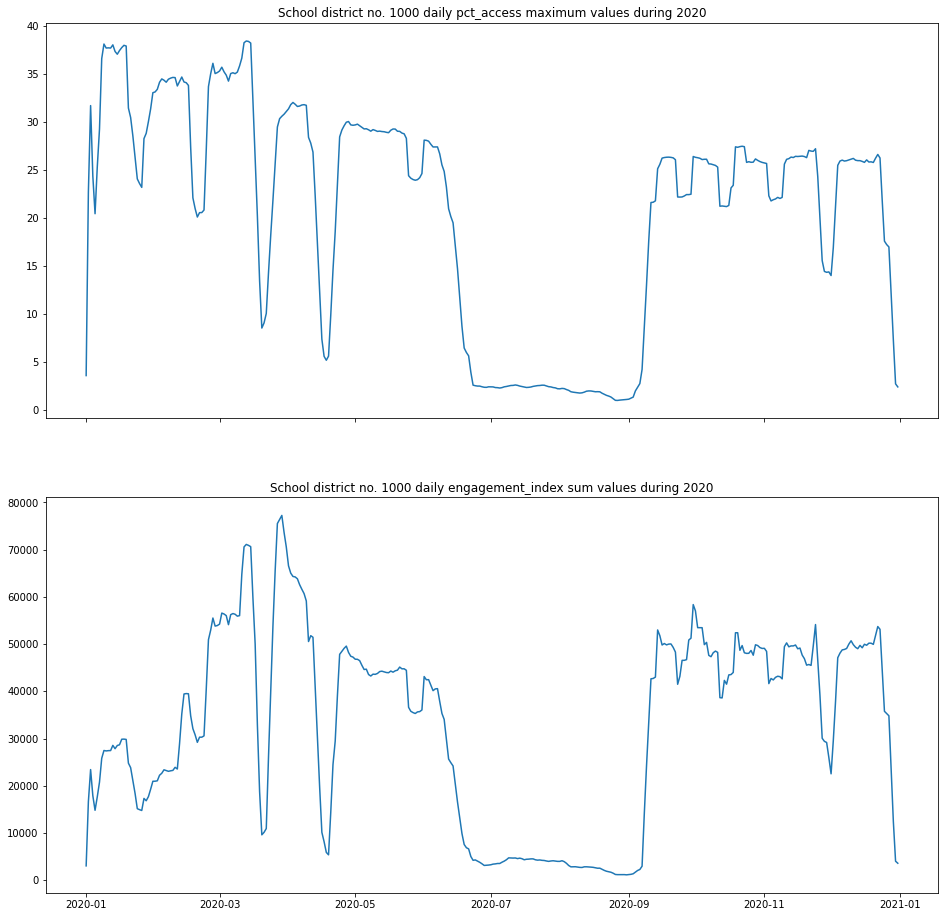

In [ ]:
#@title Insert the district number to get its engagement metrics:

district_number =  1000#@param {type:"number"}

district_metrics(district_number)

We can see for the school district no.1000 the maximum percentage of students using a digital learning product oscillates between **25-40%** on the most active days aka **max pct_access**. We can see the drop during summer vacation time, and subsequent rise in September when school year restarts.

While the total page-load events per one thousand students for all digital learning products oscillates wildly during the first part of the year (almost **80k page-load events at peak and less than 10k page-load events at bottom**) and remained more stable in the second half. This could be due to the outbreak of pandemic in the first half of 2020 with schools being closed in march. Further school district level investigation can tell us more about these oscillations.

While it is useful to have a picture on each district. It would be more interesting if we can compare them to have more insights as:

- Which are the top 10 districts for both pct_access and engagement_index?
- And which are the bottom 10?
- How big is the engagement difference between top 10 and bottom 10?
- If we choose two or more districts that we're interested. How big is their engagement difference? And what are the underlying causes?  

In [ ]:
#@title Define a function for pct_access metric:

def districts_pa(*args):  # pass a number of districts you want
  
  # Create an empty df:
  tot_df = dist_pct_access_engagement_df[dist_pct_access_engagement_df.index.get_level_values('district_id') == '1000']['pct_access_max'].rolling(7, min_periods=1).mean()
  tot_df = tot_df.to_frame()
  tot_df = tot_df.droplevel('district_id', axis=0)
  tot_df.drop(['pct_access_max'], axis=1, inplace=True)

  for dist in args:
    # Extract pct_access_max from the original dataframe:
    pa_df = dist_pct_access_engagement_df[dist_pct_access_engagement_df.index.get_level_values('district_id') == str(dist)]['pct_access_max'].rolling(7, min_periods=1).mean()
    pa_df = pa_df.to_frame()
    pa_df = pa_df.droplevel('district_id', axis=0)
    pa_df.rename(columns={"pct_access_max": "pa"+str(dist)}, inplace=True)

    # Concat to the tot_df
    tot_df = pd.concat([tot_df, pa_df], axis=1)

  # Outside the for loop:
  tot_df.index = pd.to_datetime(tot_df.index)

  # Plot the chart:
  fig, ax = plt.subplots(figsize=(16,8))
  sns.lineplot(data=tot_df, palette='tab10', linewidth=2.5)
  ax.set_title("max pct_access trend for selected districts", size=16)
  ax.set_ylabel('max pct_access')


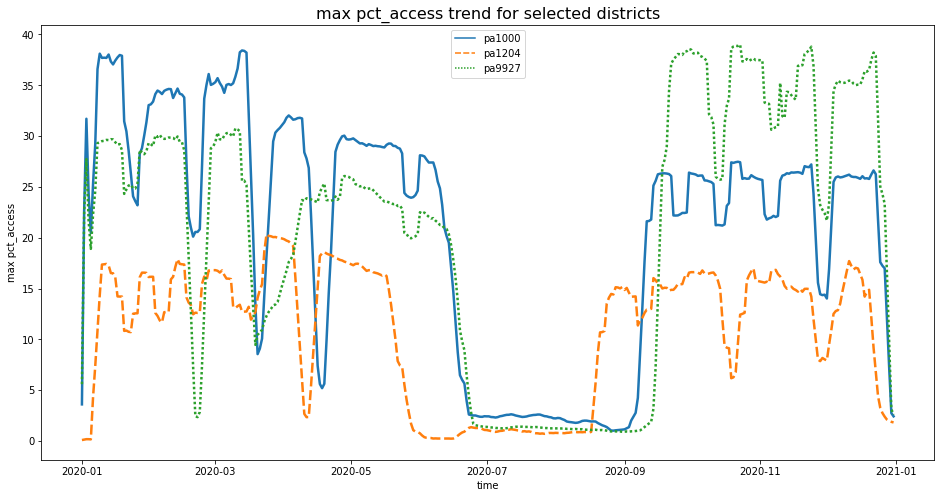

In [ ]:
districts_pa(1000, 1204, 9927)

With a basic chart we can already ask some very interesting questions on pct_access here:

- Percentage of students in the district no.1000 that have at least one page-load event of a given product and on a given day are higher than district no. 9927 during the first half of 2020. However after the summer break, the second outperforms the first. What happened in the second part of the year? What's the cause of this switching? 
- What is the reason of the underperformance of school district no. 1204? Its pct_access values are less than half of other two.

On a district level, this type of inquiry can be very interesting. We just need to select districts of our interest, make the comparison and further investigate on any substantial difference.

In [ ]:
#@title Define a function for engagement_index metric:

def districts_ei(*args):  # pass a number of districts you want
  
  # Create an empty df:
  tot_df = dist_pct_access_engagement_df[dist_pct_access_engagement_df.index.get_level_values('district_id') == '1000']['engagement_index_sum'].rolling(7, min_periods=1).mean()
  tot_df = tot_df.to_frame()
  tot_df = tot_df.droplevel('district_id', axis=0)
  tot_df.drop(['engagement_index_sum'], axis=1, inplace=True)

  for dist in args:
    # Extract engagement_index from the original dataframe:
    ie_df = dist_pct_access_engagement_df[dist_pct_access_engagement_df.index.get_level_values('district_id') == str(dist)]['engagement_index_sum'].rolling(7, min_periods=1).mean()
    ie_df = ie_df.to_frame()
    ie_df = ie_df.droplevel('district_id', axis=0)
    ie_df.rename(columns={"engagement_index_sum": "ie"+str(dist)}, inplace=True)

    # Concat to the tot_df
    tot_df = pd.concat([tot_df, ie_df], axis=1)

  # Outside the for loop, convert index to datetime:
  tot_df.index = pd.to_datetime(tot_df.index)

  # Plot the chart:
  fig, ax = plt.subplots(figsize=(16,8))
  sns.lineplot(data=tot_df, palette='tab10', linewidth=2.5)
  ax.set_title("sum engagement index trend for selected districts", size=16)
  ax.set_ylabel('sum engagement_index')


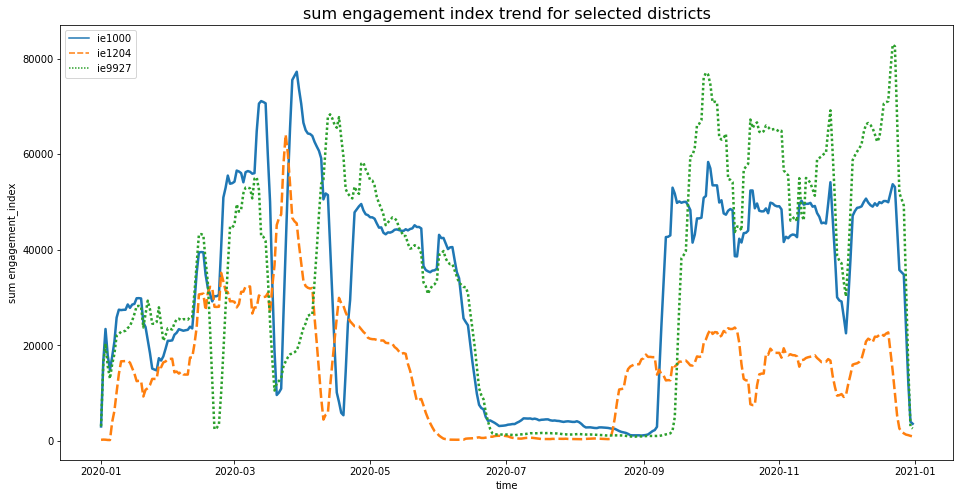

In [ ]:
districts_ei(1000, 1204, 9927)

As for engagement_index: we've choose the same three districts as before, and we can see some similaries compared to pct_access:
- District no.1000 outperforms in the first part of the year, while district no. 9927 overtakes in the second half (here it overtakes in April!);
- District no.1204 generally underperforms over the year, especially in the second half. 

## Q2: Which are the top 10 districts?

We have 215 school districts in total (233 - 18 that we have removed due to too much missing data). Let's find out which are the best performers.

We use the annual mean for both pct_access and engagement_index to decide which are the top performers and which are the bottom ones.

In [13]:
#@title Create a new dataframe with annual mean values of the metrics for all districts:

# Create a new empty DataFrame with index districts of dist_pct_access_engagement_df:
df_index = dist_pct_access_engagement_df.index.get_level_values(level=0).drop_duplicates()
dist_pct_engagement_mean_df = pd.DataFrame(index=df_index)

# Store all the annual mean metrics into two lists:
dist_pct_mean = []
dist_engagement_index_mean = []

for district, sub_df in dist_pct_access_engagement_df.groupby(level=0):
  dist_pct_mean.append(sub_df['pct_access_max'].mean())
  dist_engagement_index_mean.append(sub_df['engagement_index_sum'].mean())

# Append two lists to the new df:
dist_pct_engagement_mean_df['pct_access_mean'] = dist_pct_mean
dist_pct_engagement_mean_df['engagement_index_mean'] = dist_engagement_index_mean
dist_pct_engagement_mean_df

,pct_access_mean,engagement_index_mean
district_id,,
1000,20.634672,32360.946913
1039,15.085328,23953.756721
1044,30.956530,50708.394891
1052,27.835601,52684.947322
1131,6.576571,5323.003143
...,...,...
9778,12.436421,16300.882951
9812,17.092978,31415.260164
9839,16.975601,23386.144945


In [ ]:
#@title Top 10 pct_access districts:
top10_pa = dist_pct_engagement_mean_df.pct_access_mean.sort_values(ascending=False).head(10).to_frame()
top10_pa

,pct_access_mean
district_id,
5890,39.596776
9553,38.836366
2779,37.625601
8815,37.183718
3228,36.620246
9536,36.340305
6577,35.900246
6194,35.862814
2598,35.669044


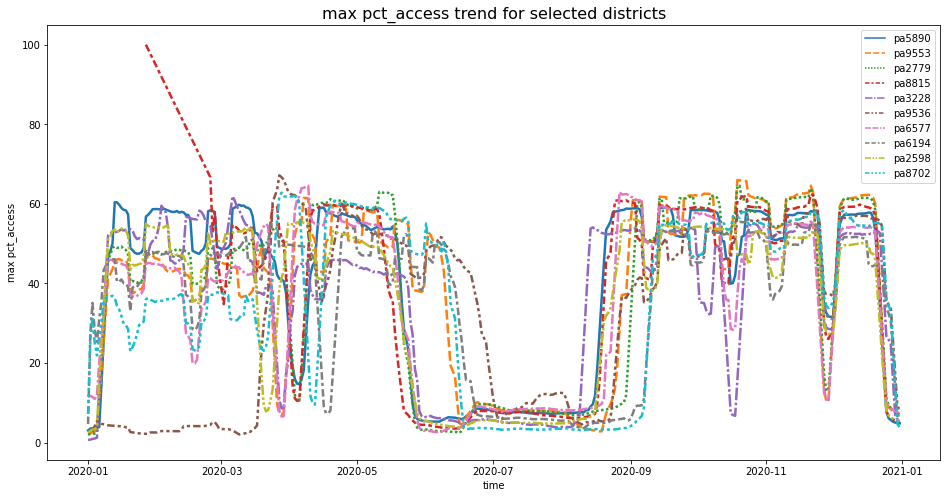

In [ ]:
districts_pa(5890, 9553, 2779, 8815, 3228, 9536, 6577, 6194, 2598, 8702)

We noticed 2 suspicious data segments:
- District no.8815 the first three months data may contain some error, as it reaches 100% as pct_access (which is quite incredible);
- District no.9536 inversely has very low data points for the first three months. It also can be a data acquisition problem.

We need to check these points with our client/colleagues who handle the data acquisition process.


With exception of these two segments, the overal picture is quite clear:
- Top 10 district for the **pct_access metric** have an average of **50-60%** value during the school calendar peak months and an **overall average annual value in the range of 35-40%**.


In [ ]:
#@title Let's link the top 10 districts with some other information to have a more complete picture:
top10_pa.index = top10_pa.index.astype(int)
districts_df.district_id = districts_df.district_id.astype(int)

top10_pa.merge(districts_df, how='left', left_index=True, right_on='district_id').set_index('district_id')

,pct_access_mean,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw
district_id,,,,,,,
5890,39.596776,Illinois,Suburb,"[0.2, 0.4[","[0.2, 0.4[","[0.18, 1[","[18000, 20000["
9553,38.836366,Illinois,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[14000, 16000["
2779,37.625601,Illinois,Rural,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[10000, 12000["
8815,37.183718,Illinois,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[14000, 16000["
3228,36.620246,Indiana,Town,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[","[8000, 10000["
9536,36.340305,New York,City,"[0.8, 1[","[0.8, 1[","[0.18, 1[",NaN
6577,35.900246,Illinois,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[10000, 12000["
6194,35.862814,Connecticut,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[",NaN
2598,35.669044,Ohio,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[",NaN


New findings emerged:
- Top 4 are all from the **State of Illinois**, half of the top10 are from this State. Even though we don't have a balanced dataset at national level and Illinois are among the top4 States in terms of school districts in our database (see above the chart of No. of school districts per State). However Utah and Massachusetts have no presence in this ranking and Connecticut has only one at the position no.7. The outperformance of Illinois' districts is an interesting point to be further studied.
- Eight of the ten districts have very **low percentage of minority students and students eligible for free/reduced-price lunch**. This might indicate a correlation between high level income at district level with high adoption of digital learning tools in the same area.
- **The district no.9536** from New York has very high percentage of black/hispanic students and eligible for free/reduced-price lunch students, both between 80-100%. This is a very encouraging news, as we might infer from this, harsh economic conditions doesn't have to be an obstacle to digital learning. Maybe other districts from poor areas can adopt some of the best practice of this district to increase their students' engagement with digital learning products.

Let's do the same list for engagement_index before we try to come up with other insights.

In [ ]:
#@title Top 10 engagement index districts:
pd.options.display.float_format = "{:,.2f}".format

top10_ei = dist_pct_engagement_mean_df.engagement_index_mean.sort_values(ascending=False).head(10).to_frame()
top10_ei

,engagement_index_mean
district_id,
8815,"100,276.01"
9536,"95,770.59"
2779,"88,344.66"
9553,"83,851.61"
6194,"76,675.84"
5890,"76,169.93"
6512,"74,277.08"
3314,"74,033.02"
9463,"71,684.57"


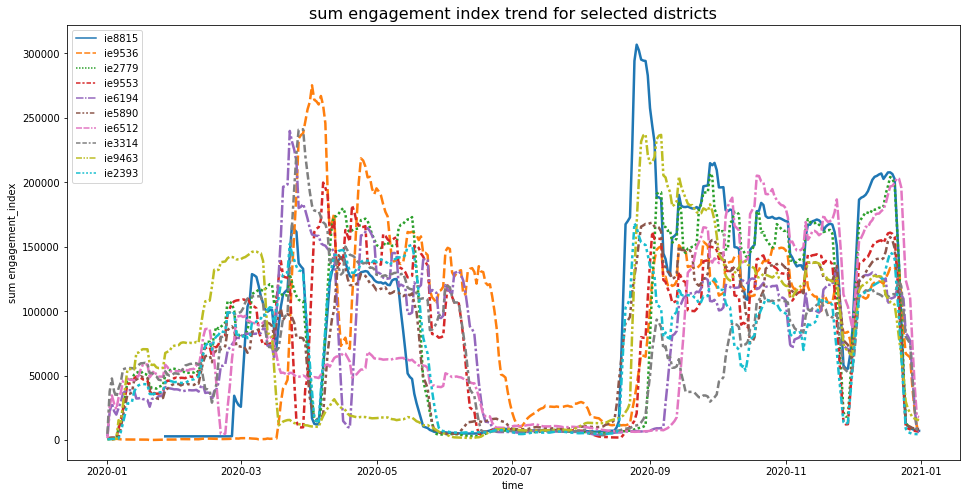

In [ ]:
districts_ei(8815, 9536, 2779, 9553, 6194, 5890, 6512, 3314, 9463, 2393)

For our top 10 districts on engagement index:
- The overall annual average total page-load events per one thousand students ranges from **71,000 to 100,000 events**.
- During peak months the metric stays **in the range 100,000 and 200,000** with highest peak touching 300,000 events.
- The trend oscillates a lot during the first half, while remained more stable during the second half of the year. We can think of school disruption and closure during pandemic outbreak in the first 3 months of 2020. As students, teachers and parents get progressively more prepared during the year, the usage of digital learning tools becomes more stable in the last few months of 2020.


In [ ]:
#@title Let's link the top 10 districts with some other information to have a more complete picture:
top10_ei.index = top10_ei.index.astype(int)

top10_ei.merge(districts_df, how='left', left_index=True, right_on='district_id').set_index('district_id')

,engagement_index_mean,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw
district_id,,,,,,,
8815,"100,276.01",Illinois,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[14000, 16000["
9536,"95,770.59",New York,City,"[0.8, 1[","[0.8, 1[","[0.18, 1[",NaN
2779,"88,344.66",Illinois,Rural,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[10000, 12000["
9553,"83,851.61",Illinois,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[14000, 16000["
6194,"76,675.84",Connecticut,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[",NaN
5890,"76,169.93",Illinois,Suburb,"[0.2, 0.4[","[0.2, 0.4[","[0.18, 1[","[18000, 20000["
6512,"74,277.08",Massachusetts,Suburb,"[0, 0.2[",NaN,"[0.18, 1[","[14000, 16000["
3314,"74,033.02",Connecticut,Rural,"[0, 0.2[","[0, 0.2[","[0.18, 1[",NaN
9463,"71,684.57",NaN,NaN,NaN,NaN,NaN,NaN


Looks like a big portion of top 10 are the same districts for both pct_access and engagement_index, as it may be expected.

In [ ]:
#@title Top performers on both metrics:

list1 = top10_pa.index.values.tolist()
list2 = top10_ei.index.values.tolist()
set1 = set(list1)
intersection = list(set1.intersection(list2))
intersection


dist_pct_engagement_mean_df.index = dist_pct_engagement_mean_df.index.astype(int)
top10_combined = dist_pct_engagement_mean_df.loc[intersection]

top10_combined.index = top10_combined.index.astype(int)
top10_combined.merge(districts_df, how='left', left_index=True, right_on='district_id').set_index('district_id').sort_values(['pct_access_mean', 'engagement_index_mean'], ascending=[False, False])


,pct_access_mean,engagement_index_mean,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw
district_id,,,,,,,,
5890,39.60,"76,169.93",Illinois,Suburb,"[0.2, 0.4[","[0.2, 0.4[","[0.18, 1[","[18000, 20000["
9553,38.84,"83,851.61",Illinois,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[14000, 16000["
2779,37.63,"88,344.66",Illinois,Rural,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[10000, 12000["
8815,37.18,"100,276.01",Illinois,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[14000, 16000["
9536,36.34,"95,770.59",New York,City,"[0.8, 1[","[0.8, 1[","[0.18, 1[",NaN
6194,35.86,"76,675.84",Connecticut,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[",NaN


Now that we have completed our top10 analysis on both metrics, we can see that it confirms our previous observations:
- **The State of Illinois** occupies half of the top10 ranking, its districts have very high performance/engagement with digital learning technologies. However we have to keep in mind that both Illinois and Connecticut are two of the four States where the bulk of the data (over 55%) is coming from. So we have to be careful here, maybe other States' districts will have higher engagement metrics if we add more data into the analysis. Same reasoning work for the locale, since we have ~60% of the data coming from Suburb, we can't make any hasty conclusion here.
- In NY City we have district no.9536 with its perculiar characteristics of high percentage of minority ethnicities students and high percentage of students eligible for free and reduced-price lunch among the top 6 in the combined ranking. This is a very encouraging news, as we might infer from this, **harsh economic conditions don't have to be an obstacle to digital learning**.

## Have analyzed the top 10, now let's have a look at the bottom 10:
## Q3: Which are the bottom 10 districts?

In [ ]:
#@title Bottom 10 pct_access districts:
bottom10_pa = dist_pct_engagement_mean_df.pct_access_mean.sort_values(ascending=True).head(10).to_frame()
bottom10_pa

,pct_access_mean
district_id,
5042,2.88
4683,2.90
3471,2.94
4373,3.49
7767,3.84
2870,4.45
3558,4.72
8017,4.87
2106,5.00


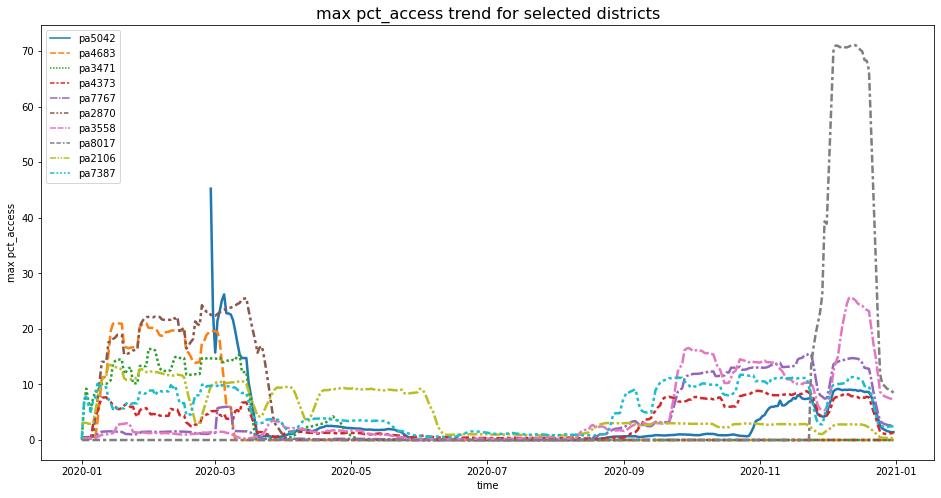

In [ ]:
b10pa = list(bottom10_pa.index)
districts_pa(*b10pa)

There are two notable examples that can be indicative of data acquisition problem:
- District no.5042 around march 2020.
- District no.8017 which have zero pct_access until december, then the data explodes.

We have to check with client/colleagues about these examples and make sure that they are correct. 

Despite the above two data examples, the overall picture is still valid. Here for our bottom10, the pct_access metric have **an average of 10-20% value during the school calendar peak months** (vs. 50-60% of the top10) and **an overall average annual value in the range of 3-6%** (vs. 35-40% of the top10).

We are seeing that for pct_access, **top10 are 2.5-6X on peak values** and **6-13X on annual average values** compared to the bottom10.

In [ ]:
#@title Bottom 10 engagement_index districts:
bottom10_ei = dist_pct_engagement_mean_df.engagement_index_mean.sort_values(ascending=True).head(10).to_frame()
bottom10_ei

,engagement_index_mean
district_id,
3471,"1,581.42"
5042,"2,722.39"
4683,"3,613.39"
4373,"4,411.79"
2870,"5,258.62"
1131,"5,323.00"
7767,"6,379.52"
7308,"6,663.86"
2567,"6,822.32"


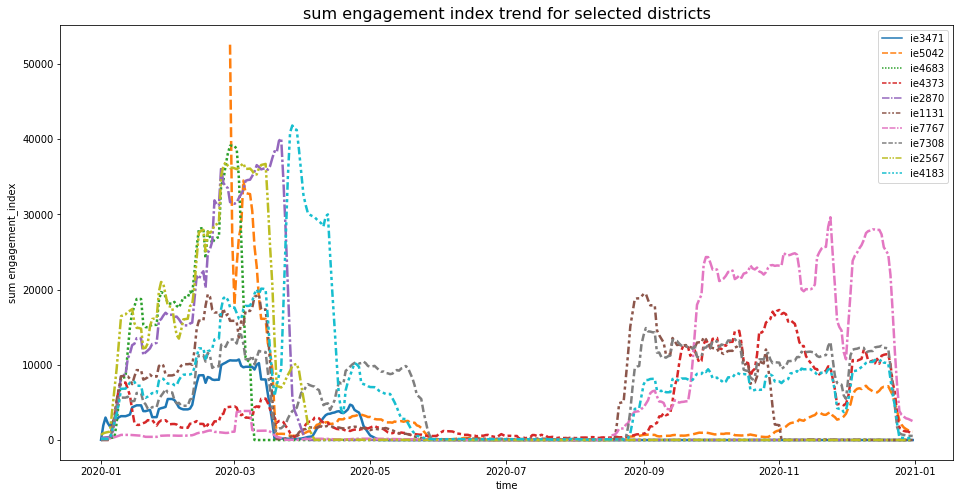

In [ ]:
b10ei = list(bottom10_ei.index)
districts_ei(*b10ei)

For our bottom 10 districts on engagement index:

- During peak months the metric stays in the **range from 10,000 to 40,000** (vs. 100,000 to 200,000 events of the top10).
- The overall annual average total page-load events per one thousand students ranges **from 1,500 to 7,500 events** (vs. 71,000 to 100,000 events of the top10).


We are seeing that for engagement_index, top10 are **2.5-20X on peak values** and **9.5-67X on annual average values** compared to the bottom10.

In [ ]:
#@title Bottom performers on both metrics:

list1 = bottom10_pa.index.values.tolist()
list2 = bottom10_ei.index.values.tolist()
set1 = set(list1)
intersection = list(set1.intersection(list2))
intersection


dist_pct_engagement_mean_df.index = dist_pct_engagement_mean_df.index.astype(int)
bottom10_combined = dist_pct_engagement_mean_df.loc[intersection]

bottom10_combined.index = bottom10_combined.index.astype(int)
bottom10_combined.merge(districts_df, how='left', left_index=True, right_on='district_id').set_index('district_id').sort_values(['pct_access_mean', 'engagement_index_mean'], ascending=[True, True])

,pct_access_mean,engagement_index_mean,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw
district_id,,,,,,,,
5042,2.88,"2,722.39",Illinois,Town,"[0.2, 0.4[","[0.8, 1[","[0.18, 1[","[10000, 12000["
4683,2.90,"3,613.39",Texas,Suburb,"[0.4, 0.6[","[0.4, 0.6[","[0.18, 1[","[8000, 10000["
3471,2.94,"1,581.42",NaN,NaN,NaN,NaN,NaN,NaN
4373,3.49,"4,411.79",Utah,City,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[8000, 10000["
7767,3.84,"6,379.52",North Carolina,City,"[0.4, 0.6[","[0.6, 0.8[","[0.18, 1[","[10000, 12000["
2870,4.45,"5,258.62",Indiana,Suburb,"[0.8, 1[","[0.6, 0.8[","[0.18, 1[","[8000, 10000["


Analyzing the bottom10, we noticed the following:

- Both pct_access and engagement_index during 2020 are on average **around or less than 1/10** from the best. The differences are very big. Now, there's maybe more than one way to interpret this result. As if a school adopts more in-person teaching, consequently its students will use relatively less digital learning tools. However in a pandemic year like 2020, we would expect the lower engagement metrics more as a negative sign than as a positive one. Especially as we know in the U.S. almost all States have closed schools around the end of March. 
- A curious finding that **district no.5042** is situated in Illinois! We've already seen that quite a lot of top districts are from Illinois. So the fact that one of the worst is also in the same State, we wonder why of this huge difference. Maybe the district no.5042 can learn something from its neighbouring districts.
- **Lower income districts might have a correlation with lower performance on digital learnings**, 4 out of 6 bottom districts have pretty high percentage of students eligible for free/reduced-price lunch.

Clearly something is not working in these districts, it might due to economic reason. But we have seen case like the district in NY from top10, low income doesn't necessary have to be an obtacle. To better understand the underlying causes, further research must be done including interviews to the teachers, to the parents etc.



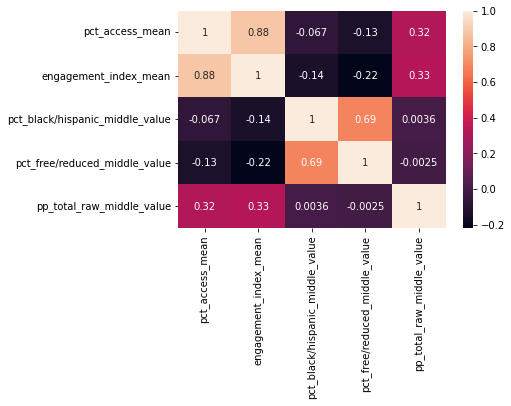

In [49]:
#@title Correlation Matrix with Heatmap:

# Convert index as int
dist_pct_engagement_mean_df.index = dist_pct_engagement_mean_df.index.astype(int)
# Merge the two dfs
dist_pct_engagement_mean_sf_df = dist_pct_engagement_mean_df.merge(districts_df, how='left', left_index=True, right_on='district_id').set_index('district_id')
# Drop qualitative columns and county_connections_ratio which we don't use
dist_pct_engagement_mean_sf_df.drop(['state', 'locale', 'county_connections_ratio'], axis=1, inplace=True)

# Calculate middle value for the remaining three columns:

def middle_value(df, col):
  lower_limit = []
  upper_limit = []

  for index, row in df.iterrows():
    data = row[col]
    if(not pd.isnull(data)):
      lower_value = data.split(",")[0].split("[")[1]
      upper_value = data.split(",")[1].split("[")[0].strip()
      lower_limit.append(lower_value)
      upper_limit.append(upper_value)
    else:
      lower_limit.append(None)
      upper_limit.append(None)
  
  col_name1 = col + '_lower_limit'
  col_name2 = col + '_upper_limit'
  col_name3 = col + '_middle_value'

  df[col_name1] = lower_limit
  df[col_name2] = upper_limit

  df[col_name1] = pd.to_numeric(lower_limit)
  df[col_name2] = pd.to_numeric(upper_limit)
  df[col_name3] = (df[col_name1] + df[col_name2]) / 2

  return df

for col in dist_pct_engagement_mean_sf_df.columns[2:5]:
  dist_pct_engagement_mean_sf_df = middle_value(dist_pct_engagement_mean_sf_df, col)


# Drop the unuseful columns
dist_pct_engagement_mean_sf_df.drop(['pct_black/hispanic', 
                                     'pct_free/reduced', 
                                     'pp_total_raw', 
                                     'pct_black/hispanic_lower_limit',
                                     'pct_black/hispanic_upper_limit',
                                     'pct_free/reduced_lower_limit',
                                     'pct_free/reduced_upper_limit',
                                     'pp_total_raw_lower_limit',
                                     'pp_total_raw_upper_limit'], axis=1, inplace=True)

# Calculate correlation matrix:
my_corr = dist_pct_engagement_mean_sf_df[['pct_access_mean', 
                                'engagement_index_mean', 
                                'pct_black/hispanic_middle_value', 
                                'pct_free/reduced_middle_value', 
                                'pp_total_raw_middle_value' ]].corr()

sns.heatmap(my_corr, annot=True);

We have merged the information about percentage of minority students and students eligible for free/reduced price lunch into all the districts with their engagement metrics. By analyzing the correlation matrix, we can see some reasonable connections:

- Both engagement metrics: pct_access and engagement_index move together (corr of 0.88).
- Percentage of minority students and eligible for free/reduced price lunch have slightly negative correlation. Lower incomes are negatively correlated with digital learning engagement.
- Per-pupil total expenditure data correlates positively with digital learning engagement.

## Q4: How is the digital learning picture for each locale type?

As we have 4 types of locale: Suburb, Rural, City, Town. It would be interesting to see how big is the difference in digital learning among them.

For pct_access: first we compute the max_pct_access as we have done for the districts analysis. Then we average all the districts values among the same type of locale for each day of the 2020. E.g. if 'City' has 20 districts in total, we average the max_pct_access over these 20 districts from Jan. 1st to Dec. 31st. We do so for each locale type.

For engagement_index: the only difference is instead of max value, we use the sum for each day aggregated on district level. Then we average over districts. 

In [7]:
# First, we merge the two datasets:
engagement_districts_df = pd.merge(engagement_df, districts_df, on=['district_id'])
engagement_districts_df.sample(100)

,time,lp_id,pct_access,engagement_index,district_id,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw
21793565,2020-12-09,28939.0,0.00,0.00,5006,Massachusetts,Suburb,"[0, 0.2[",NaN,"[0.18, 1[","[14000, 16000["
6500541,2020-10-27,96864.0,0.24,13.04,1877,Illinois,Rural,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[12000, 14000["
7555101,2020-05-21,41424.0,0.01,4.52,3322,California,City,"[0, 0.2[","[0, 0.2[","[0.18, 1[",NaN
2608163,2020-10-01,30762.0,0.00,0.00,3393,NaN,NaN,NaN,NaN,NaN,NaN
10487388,2020-05-07,44853.0,0.01,0.17,1624,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
8353465,2020-03-24,12803.0,0.02,0.45,9303,Massachusetts,Suburb,"[0, 0.2[",NaN,"[0.18, 1[","[14000, 16000["
22321629,2020-12-15,64998.0,1.62,257.40,4165,NaN,NaN,NaN,NaN,NaN,NaN
9082307,2020-08-11,26533.0,0.00,0.00,4569,Connecticut,City,"[0.6, 0.8[","[0.4, 0.6[","[0.18, 1[",NaN
4191566,2020-03-11,10450.0,0.01,1.25,4629,Illinois,Suburb,"[0, 0.2[","[0.2, 0.4[","[0.18, 1[","[16000, 18000["


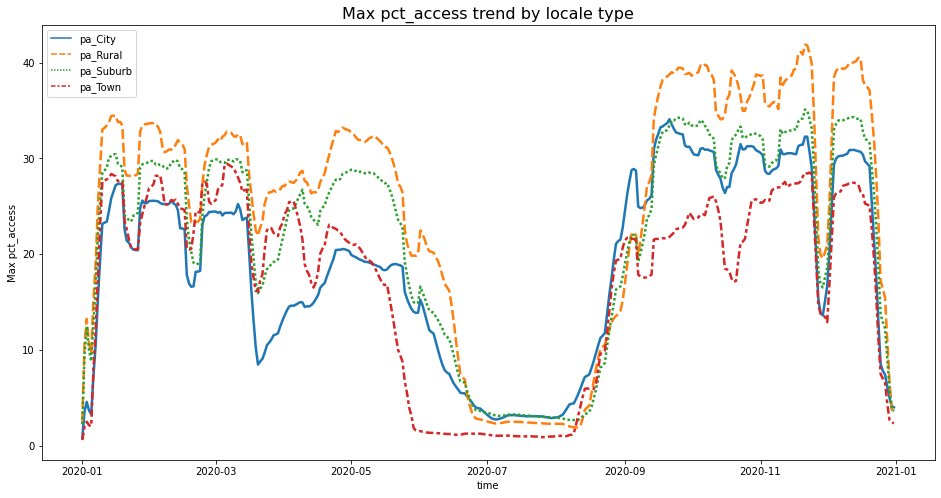

In [47]:
#@title pct_access metric per locale type:

temp_df = engagement_districts_df.groupby(['locale','district_id', 'time']).pct_access.max()
temp_df = temp_df.to_frame()
locale_pct_access_df = temp_df.groupby(['locale', 'time']).pct_access.mean().to_frame()

def locale_pa():  
  # Create an empty df:
  tot_df = locale_pct_access_df[locale_pct_access_df.index.get_level_values('locale') == 'City']['pct_access'].rolling(7, min_periods=1).mean()
  tot_df = tot_df.to_frame()
  tot_df = tot_df.droplevel('locale', axis=0)
  tot_df.drop(['pct_access'], axis=1, inplace=True)

  # Create a list of locale types
  locale_list = list(locale_pct_access_df.index.unique(level='locale'))

  for locale in locale_list:
    # Extract pct_access values from dataframe:
    pa_df = locale_pct_access_df[locale_pct_access_df.index.get_level_values('locale') == locale]['pct_access'].rolling(7, min_periods=1).mean()
    pa_df = pa_df.to_frame()
    pa_df = pa_df.droplevel('locale', axis=0)
    pa_df.rename(columns={"pct_access": "pa_"+ locale}, inplace=True)

    # Concat to the tot_df
    tot_df = pd.concat([tot_df, pa_df], axis=1)

  # Outside the for loop:
  tot_df.index = pd.to_datetime(tot_df.index)

  # Plot the chart:
  fig, ax = plt.subplots(figsize=(16,8))
  sns.lineplot(data=tot_df, palette='tab10', linewidth=2.5)
  ax.set_title("Max pct_access trend by locale type", size=16)
  ax.set_ylabel('Max pct_access')

# Call the function
locale_pa()

We can see that on average **Rural districts have higher pct_access**, while Town districts are performing the worst during second half of the year. Although the difference is not that big as we've seen previously on distrct level.



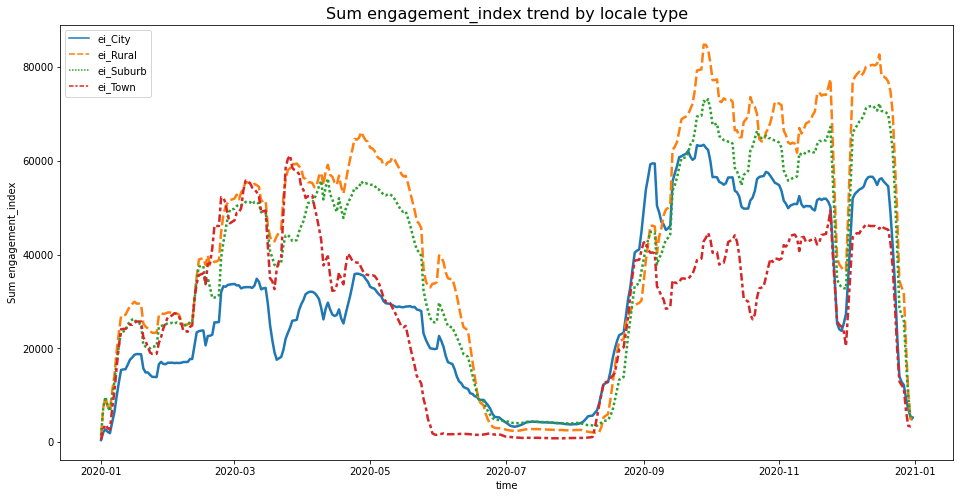

In [48]:
#@title engagement_index metric per locale type:

temp_df = engagement_districts_df.groupby(['locale','district_id', 'time']).engagement_index.sum()
temp_df = temp_df.to_frame()
locale_engagement_index_df = temp_df.groupby(['locale', 'time']).engagement_index.mean().to_frame()

def locale_ei():  
  # Create an empty df:
  tot_df = locale_engagement_index_df[locale_engagement_index_df.index.get_level_values('locale') == 'City']['engagement_index'].rolling(7, min_periods=1).mean()
  tot_df = tot_df.to_frame()
  tot_df = tot_df.droplevel('locale', axis=0)
  tot_df.drop(['engagement_index'], axis=1, inplace=True)

  # Create a list of locale types
  locale_list = list(locale_engagement_index_df.index.unique(level='locale'))

  for locale in locale_list:
    # Extract pct_access values from dataframe:
    ei_df = locale_engagement_index_df[locale_engagement_index_df.index.get_level_values('locale') == locale]['engagement_index'].rolling(7, min_periods=1).mean()
    ei_df = ei_df.to_frame()
    ei_df = ei_df.droplevel('locale', axis=0)
    ei_df.rename(columns={"engagement_index": "ei_"+ locale}, inplace=True)

    # Concat to the tot_df
    tot_df = pd.concat([tot_df, ei_df], axis=1)

  # Outside the for loop:
  tot_df.index = pd.to_datetime(tot_df.index)

  # Plot the chart:
  fig, ax = plt.subplots(figsize=(16,8))
  sns.lineplot(data=tot_df, palette='tab10', linewidth=2.5)
  ax.set_title("Sum engagement_index trend by locale type", size=16)
  ax.set_ylabel('Sum engagement_index')

# Call the function
locale_ei()

For engagement_index we **also have Rural as the best of the four on average**. While City has trudged in the first half, the second part of year is seeing difference in general getting smaller.

## Q5: Which are the best States? And Which are the worst?

Here we must not hurry to make comparison. We already know that our datasets are not uniform, and there are 4 States who count for more than 55% of the data. Therefore, we first need to establish a cut-off threshold to drop the States with too few data points.

We can see that Florida, Minnesota, Arizona, North Dakota only have 1 school district each. While Minnesota, Arizona, North Dakota, New Hampshire have the fewest data points for both pct_access and engagement_index.

We'll establish a cut-off at 100K data points for both pct_access and engagement_index, and drop States with less than 100K data points. The goal is to allow a certain comparability, as too fewer data will probabily give us a distorted picture of the reality.


In [ ]:
#@title We drop the States of Minnesota, Arizona, North Dakota, New Hampshire from our analysis, as they contain too few districts or examples.

engagement_districts_df.drop(engagement_districts_df[engagement_districts_df.state == 'Minnesota'].index, inplace=True)
engagement_districts_df.drop(engagement_districts_df[engagement_districts_df.state == 'Arizona'].index, inplace=True)
engagement_districts_df.drop(engagement_districts_df[engagement_districts_df.state == 'North Dakota'].index, inplace=True)
engagement_districts_df.drop(engagement_districts_df[engagement_districts_df.state == 'New Hampshire'].index, inplace=True)
engagement_districts_df.drop(engagement_districts_df[engagement_districts_df.state == 'Not disclosed'].index, inplace=True)


First, let's define our metrics for comparison and ranking among States.

We decide to take the average value amongs all districts in a given State as the State value. So to recap:

- For pct_access, we have the max value from each school district (we don't care which technology product in this case, if on a given day the max pct_access is 10%, we consider 10% for that day). Once we have the daily max pct_access for the whole year for each district in the State, we average them out to get the annual State level data.

- For the engagement_index, we used the sum instead of max value. So we have the cumulative daily value for the whole year for each district in the State. As above, we average them out among all districts to come up with the State level metric.

We will explain further once we have calculated the metrics and plotted the charts.

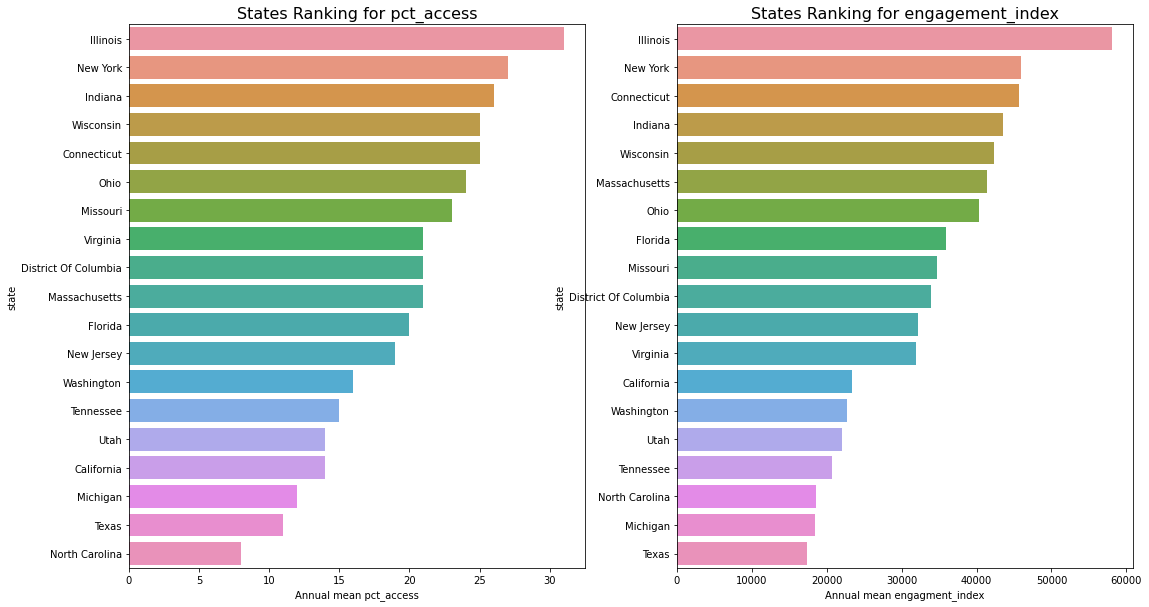

In [ ]:
#@title State level **pct_access** and **engagement_index** ranking:

# states_pct_access_df.loc['California']
# states_pct_access_df.loc['California'].mean(axis=0).head(20)
# df = pd.DataFrame(states_pct_access_df.loc['California'].mean(axis=0))
# df.index = df.index.droplevel()
# df.transpose()

# Extract pct_access data from the df:
states_pct_access_df = engagement_districts_df.groupby(['state', 'district_id', 'time']).pct_access.max().to_frame().unstack()

# Create a new temporary DataFrame with States as index:
states_index = states_pct_access_df.index.get_level_values(level=0).drop_duplicates()
states_pct_index = pd.DataFrame(index=states_index)

frames = []

# For each State we calculate the mean of pct_access among its districts:
for state, sub_df in states_pct_access_df.groupby(level=0):
  new_df = pd.DataFrame(states_pct_access_df.loc[state].mean(axis=0))
  new_df.index = new_df.index.droplevel()
  frames.append(new_df.transpose())

states_pct_temp = pd.concat(frames)
states_pct_mean_df = states_pct_temp.set_index(states_pct_index.index)

# States Ranking for pct_access:
states_pa = states_pct_mean_df.mean(axis=1).sort_values(ascending=False).to_frame()

# plt.figure(figsize=(20,10))
# sns.barplot(x=states_pa.values.flatten().astype('int'), y=states_pa.index)
# plt.title('States Ranking for pct_access', size=20)
# plt.ylabel('States')
# plt.xlabel('Annual mean pct_access');


# Extract engagement_index data from the df:
states_engagement_index_df = engagement_districts_df.groupby(['state', 'district_id', 'time']).engagement_index.sum().to_frame().unstack()

# Create a new temporary DataFrame with States as index:
states_index = states_engagement_index_df.index.get_level_values(level=0).drop_duplicates()
states_engagement_index_index = pd.DataFrame(index=states_index)

frames = []

for state, sub_df in states_engagement_index_df.groupby(level=0):
  new_df = pd.DataFrame(states_engagement_index_df.loc[state].mean(axis=0))
  new_df.index = new_df.index.droplevel()
  frames.append(new_df.transpose())

states_engagement_temp = pd.concat(frames)
# engagement_index for each State:
states_engagement_mean_df = states_engagement_temp.set_index(states_engagement_index_index.index)

# States Ranking for engagement_index:
states_ei = states_engagement_mean_df.mean(axis=1).sort_values(ascending=False).to_frame()


# plt.figure(figsize=(20,10))
# sns.barplot(x=states_ei.values.flatten().astype('int'), y=states_ei.index)
# plt.title('States Ranking for engagement_index', size=20)
# plt.ylabel('States')
# plt.xlabel('Annual mean engagment_index');

#Plot the charts:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(18, 10))

sns.barplot(x=states_pa.values.flatten().astype('int'), y=states_pa.index, ax=ax0)
ax0.set_title('States Ranking for pct_access', size=16)
ax0.set_xlabel('Annual mean pct_access')

sns.barplot(x=states_ei.values.flatten().astype('int'), y=states_ei.index, ax=ax1)
ax1.set_title('States Ranking for engagement_index', size=16)
ax1.set_xlabel('Annual mean engagment_index')

plt.show();

In [ ]:
#@title List of unique values for State features

# features = ['locale', 'pct_black/hispanic', 'pct_free/reduced', 'pp_total_raw']

# for feature in features:
#   print(feature + ': ')
#   my_list = list(districts_df[feature].unique())
#   for x in range(len(my_list)):
#     print('\t', my_list[x])



In [ ]:
#@title Split numerica features into upper and lower limits:

def percentage_columns(df, col):
  lower_limit = []
  upper_limit = []

  for index, row in df.iterrows():
    data = row[col]
    if(not pd.isnull(data)):
      lower_value = data.split(",")[0].split("[")[1]
      upper_value = data.split(",")[1].split("[")[0].strip()
      lower_limit.append(lower_value)
      upper_limit.append(upper_value)
    else:
      lower_limit.append(None)
      upper_limit.append(None)
  
  col_name1 = col + '_lower_limit'
  col_name2 = col + '_upper_limit'
  col_name3 = col + '_range'
  df[col_name1] = lower_limit
  df[col_name2] = upper_limit
  df[col_name3] = df[col_name1] + '-' + df[col_name2]

  return df


districts_copy = districts_df.copy()
for col in districts_copy.columns[3:7]:
  districts_copy = percentage_columns(districts_copy, col)

# districts_copy = districts_copy.dropna()


In [ ]:
#@title Define Plotting Functions:

def filter_state(df, col, state):
  return df[['state', 'district_id', col]].dropna().loc[df['state']==state]

def display(df, state):
  col1 = 'pct_black/hispanic_range'
  col2 = 'pct_free/reduced_range'
  col3 = 'pp_total_raw_range'
  col4 = 'locale'

  df1 = filter_state(df, col1, state)
  df2 = filter_state(df, col2, state)
  df3 = filter_state(df, col3, state)
  df4 = filter_state(df, col4, state)

  # Plot the charts
  fig, ax = plt.subplots(2,2, figsize=(16,16))
  fig.suptitle(state + "'s Characteristics", fontweight='bold', fontsize=20)

  plot_order1 = sorted(list(df1[col1].unique()))
  sns.countplot(y=col1, data=df1, order=plot_order1, ax=ax[0,0])
  ax[0,0].set_title('% of Black/Hispanic')
  ax[0,0].set_ylabel(None)

  plot_order2 = sorted(list(df2[col2].unique()))
  sns.countplot(y=col2, data=df2, order=plot_order2, ax=ax[0,1])
  ax[0,1].set_title('% of Eligible for Free/Reduced Lunch Price')
  ax[0,1].set_ylabel(None)

  plot_order3 = sorted(list(df3[col3].unique()))
  sns.countplot(y=col3, data=df3, order=plot_order3, ax=ax[1,0])
  ax[1,0].set_title('Per-pupil total expenditure')
  ax[1,0].set_ylabel(None)

  sns.countplot(y=col4, data=df4, ax=ax[1,1])
  ax[1,1].set_title('Locale distribution')
  ax[1,1].set_ylabel(None)

  # plt.tight_layout()
  plt.show()

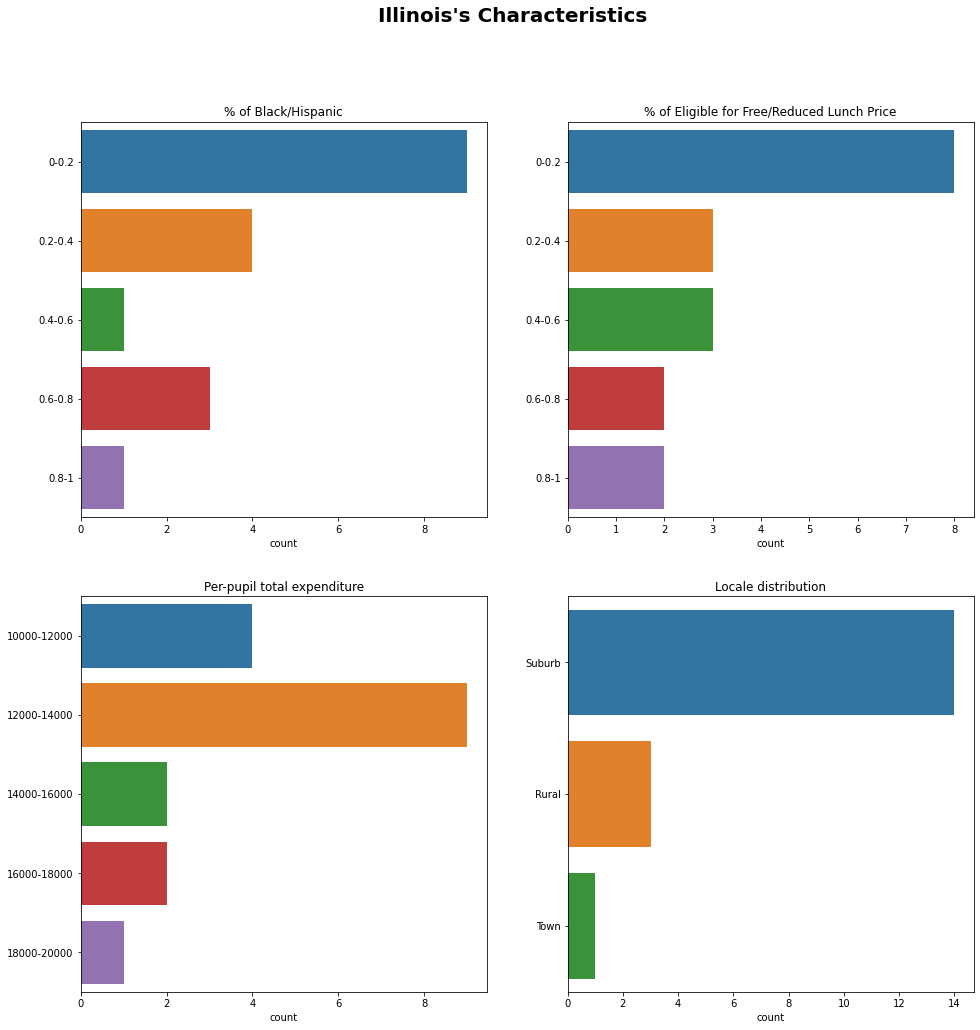

In [ ]:
#@title Insert the name of the State to see its characteristics:

state_name = 'Illinois' #@param {type:"string"}

display(districts_copy, state_name)

We know very well that our dataset is not balanced. Therefore any findings are now linked to the data available at the present. If in the future, we can add new data, we very likely will see a different picture. 

That said. As for now, we have some confirmation with our previous analysis on districs:

- Best States consist of: **Illinois, New York, Indiana, Connecticut/Wisconsin**. 
- While at bottom of the ranking we can find: **Texas, Michigan, North Carolina**. (might partially due to the lower sample size of data. We can't have a confident conclusion unless we have more data on these States.)
- **California**'s performance are quite bad compared to the best. Both metrics pct_access and engagement_index are only 1/2 of those at top of the ranking.
- From a preliminary analysis of the characteristics of each State in both best and worst rankings. We have noticed that the percentage of Black/Hispanic Students and Eligible for Free/Reduced Lunch Price are both generally high in the worst States and generally low in the best States. Which indicates **a negative correlation between families' economic conditions and usage of digital learning tools**. This finding partially matches with our previous analysis on Correlation Matrix with both pct_black/hispanic and pct_free/reduced having negative correlation values around -0.20. However this is at odds with the findings of the survey conducted by AP and Chalkbeat in 2020 which states that districts with high percentage of students of color are likely to start online. We may need to investigate further into details of such contradictory findings.

#Let's focus now on our top digital learning products:

## Load products_info data into DataFrame

### Product information data
> The product file ```products_info.csv``` includes information about the characteristics of the top 372 products with most users in 2020. The categories listed in this file are part of LearnPlatform's product taxonomy. 

📝 Some products may not have labels due to being duplicate, lack of accurate url or other reasons.

| Name                       | Description                                                                                                                                                                                                                                                                                                                    |
|----------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| LP ID                      | The unique identifier of the product                                                                                                                                                                                                                                                                                           |
| URL                        | Web Link to the specific product                                                                                                                                                                                                                                                                                               |
| Product Name               | Name of the specific product                                                                                                                                                                                                                                                                                                   |
| Provider/Company Name      | Name of the product provider                                                                                                                                                                                                                                                                                                   |
| Sector(s)                  | Sector of education where the product is used                                                                                                                                                                                                                                                                                  |
| Primary Essential Function | The basic function of the product. There are two layers of labels here. Products are first labeled as one of these three categories: LC = Learning & Curriculum, CM = Classroom Management, and SDO = School & District Operations. Each of these categories have multiple sub-categories with which the products were labeled |
|                            |                                                                                                                                                                         

We split the Primary Essential Function into two separate columns as there are two layers/levels of specifications here.

In [49]:
products_df = pd.read_csv('/content/learnplatform-covid19-impact-on-digital-learning/products_info.csv')

In [51]:
products_df

,LP ID,URL,Product Name,Provider/Company Name,Sector(s),Primary Essential Function
0,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms
1,66933,https://abcmouse.com,ABCmouse.com,"Age of Learning, Inc",PreK-12,LC - Digital Learning Platforms
2,50479,https://www.abcya.com,ABCya!,"ABCya.com, LLC",PreK-12,"LC - Sites, Resources & Reference - Games & Si..."
3,92993,http://www.aleks.com/,ALEKS,McGraw-Hill PreK-12,PreK-12; Higher Ed,LC - Digital Learning Platforms
4,73104,https://www.achieve3000.com/,Achieve3000,Achieve3000,PreK-12,LC - Digital Learning Platforms
...,...,...,...,...,...,...
367,88065,https://dochub.com/,DocHub,DocHub,PreK-12; Higher Ed; Corporate,SDO - Other
368,37805,http://google.com/slides/about/,Google Slides,Google LLC,PreK-12; Higher Ed; Corporate,LC - Content Creation & Curation
369,32555,http://www.innersloth.com/gameAmongUs.php,Among Us,InnerSloth,PreK-12; Higher Ed,"LC - Sites, Resources & Reference - Games & Si..."
370,87841,http://edpuzzle.com,Edpuzzle - Free (Basic Plan),EDpuzzle Inc.,NaN,NaN


In [ ]:
products_df.columns

Index(['LP ID', 'URL', 'Product Name', 'Provider/Company Name', 'Sector(s)',
       'Primary Essential Function'],
      dtype='object')

As per instruction, the last column 'Primary Essential Function' actually contains two layers of information. As first thing, we therefore split it as following:

In [52]:
products_df['func_category']= products_df['Primary Essential Function'].str.split(' - ', 1).str[0]
products_df['primary_function']= products_df['Primary Essential Function'].str.split(' - ', 1).str[1]
products_df

,LP ID,URL,Product Name,Provider/Company Name,Sector(s),Primary Essential Function,func_category,primary_function
0,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms,LC,Digital Learning Platforms
1,66933,https://abcmouse.com,ABCmouse.com,"Age of Learning, Inc",PreK-12,LC - Digital Learning Platforms,LC,Digital Learning Platforms
2,50479,https://www.abcya.com,ABCya!,"ABCya.com, LLC",PreK-12,"LC - Sites, Resources & Reference - Games & Si...",LC,"Sites, Resources & Reference - Games & Simulat..."
3,92993,http://www.aleks.com/,ALEKS,McGraw-Hill PreK-12,PreK-12; Higher Ed,LC - Digital Learning Platforms,LC,Digital Learning Platforms
4,73104,https://www.achieve3000.com/,Achieve3000,Achieve3000,PreK-12,LC - Digital Learning Platforms,LC,Digital Learning Platforms
...,...,...,...,...,...,...,...,...
367,88065,https://dochub.com/,DocHub,DocHub,PreK-12; Higher Ed; Corporate,SDO - Other,SDO,Other
368,37805,http://google.com/slides/about/,Google Slides,Google LLC,PreK-12; Higher Ed; Corporate,LC - Content Creation & Curation,LC,Content Creation & Curation
369,32555,http://www.innersloth.com/gameAmongUs.php,Among Us,InnerSloth,PreK-12; Higher Ed,"LC - Sites, Resources & Reference - Games & Si...",LC,"Sites, Resources & Reference - Games & Simulat..."
370,87841,http://edpuzzle.com,Edpuzzle - Free (Basic Plan),EDpuzzle Inc.,NaN,NaN,NaN,NaN


In [ ]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372 entries, 0 to 371
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   LP ID                       372 non-null    int64 
 1   URL                         372 non-null    object
 2   Product Name                372 non-null    object
 3   Provider/Company Name       371 non-null    object
 4   Sector(s)                   352 non-null    object
 5   Primary Essential Function  352 non-null    object
 6   func_category               352 non-null    object
 7   primary_function            352 non-null    object
dtypes: int64(1), object(7)
memory usage: 23.4+ KB


In [ ]:
print(products_df["LP ID"].nunique())
print(engagement_df["lp_id"].nunique())

372
8647


We can see from above that in the products_df we have the top 372 products information, while in our engagement_df we have a lot more products. So when we merge the datasets, we have to be mindful of this.

### Top 10 companies in terms of number of products:

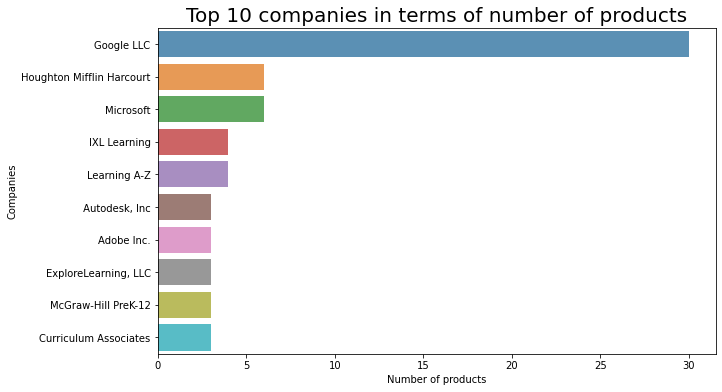

In [59]:
companies_num_prod = products_df['Provider/Company Name'].value_counts(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x = companies_num_prod.values, y = companies_num_prod.index, alpha=0.8)
plt.title('Top 10 companies in terms of number of products', size=20)
plt.ylabel('Companies')
plt.xlabel('Number of products')
plt.show();

The chart shows the importance of Google for digital learning, although we still have to dig deep on which specific products are the most used by the students. 

### Sectors Distribution

In [ ]:
products_df['Sector(s)'].unique()

array(['PreK-12', 'PreK-12; Higher Ed', 'PreK-12; Higher Ed; Corporate',
       nan, 'Corporate', 'Higher Ed; Corporate'], dtype=object)

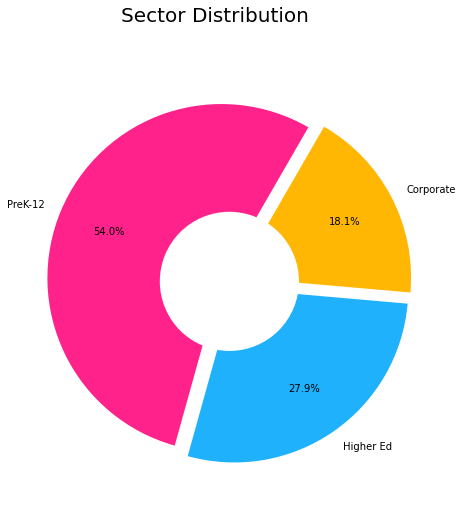

In [60]:
c1=c2=c3=0
for s in products_df["Sector(s)"]:
    if(not pd.isnull(s)):
        s = s.split(";")
        for i in range(len(s)):
            sub = s[i].strip()
            if(sub == 'PreK-12'): c1+=1
            if(sub == 'Higher Ed'): c2+=1
            if(sub == 'Corporate'): c3+=1

fig, ax  = plt.subplots(figsize=(16, 8))
fig.suptitle('Sector Distribution', size = 20)
explode = (0.05, 0.05, 0.05)
labels = ['PreK-12','Higher Ed','Corporate']
sizes = [c1,c2, c3]
ax.pie(sizes, explode=explode,startangle=60, labels=labels,autopct='%1.1f%%', pctdistance=0.7, colors=["#ff228a","#20b1fd","#ffb703"])
ax.add_artist(plt.Circle((0,0),0.4,fc='white'))
plt.show();

The majority of products are PreK-12, this matches well with our goal of analysis.

### Function Categories Distribution

In [61]:
products_df['func_category'].value_counts()

LC           272
CM            34
SDO           30
LC/CM/SDO     16
Name: func_category, dtype: int64

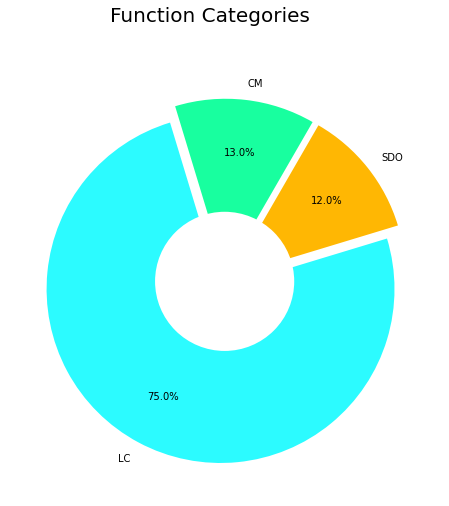

In [62]:
c1=c2=c3=0

for s in products_df["func_category"]:
    if(not pd.isnull(s)):
        c1 += s.count("CM")
        c2 += s.count("LC")
        c3 += s.count("SDO")

fig, ax  = plt.subplots(figsize=(16, 8))
fig.suptitle('Function Categories', size = 20)
explode = (0.05, 0.05, 0.05)
labels = ['CM','LC','SDO']
sizes = [c1, c2, c3]
ax.pie(sizes, explode=explode,startangle=60, labels=labels,autopct='%1.1f%%', pctdistance=0.7, colors=["#18ff9f","#2cfbff","#ffb703"])
ax.add_artist(plt.Circle((0,0),0.4,fc='white'))
plt.show()

 LC = Learning & Curriculum is the overwhelming majority function category, which matches well with our objective.

### Primary Functions Ranking


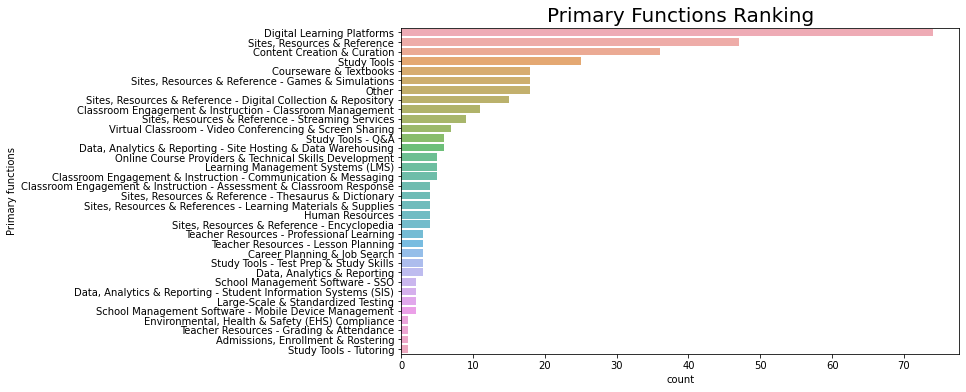

In [63]:
func_dist = products_df['primary_function'].value_counts(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x = func_dist.values, y = func_dist.index, alpha=0.8)
plt.title('Primary Functions Ranking', size=20)
plt.ylabel('Primary functions')
plt.xlabel('count')
plt.show();

As expected the higher counts are related to functions focused on students learning like: Digital Learning Platforms, Resources & Reference, Content Creation & Curation. 

While the lower end is populated with school management software, admissions, enrollment, teacher resources etc.

## Now we want to see more about the relationship betweeen technology products and its engagement metrics.

## Merge products_df with engagement_df

Now we merge the two DataFrames, we have to remember in the products_df we have the top 372 products information, while in our engagement_df we have a lot more around 8600 products majority of which we don't have information.

In [50]:
products_engagement_df = pd.merge(products_df, engagement_df, left_on='LP ID', right_on='lp_id')
products_engagement_df

,LP ID,URL,Product Name,Provider/Company Name,Sector(s),Primary Essential Function,time,lp_id,pct_access,engagement_index,district_id
0,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms,2020-01-07,13117.0,0.01,0.09,4183
1,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms,2020-01-17,13117.0,0.01,0.09,4183
2,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms,2020-01-21,13117.0,0.01,0.18,4183
3,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms,2020-01-23,13117.0,0.01,0.09,4183
4,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms,2020-01-24,13117.0,0.01,0.09,4183
...,...,...,...,...,...,...,...,...,...,...,...
11691582,87841,http://edpuzzle.com,Edpuzzle - Free (Basic Plan),EDpuzzle Inc.,NaN,NaN,2020-12-03,87841.0,0.02,0.60,4165
11691583,87841,http://edpuzzle.com,Edpuzzle - Free (Basic Plan),EDpuzzle Inc.,NaN,NaN,2020-12-07,87841.0,0.02,0.30,4165
11691584,87841,http://edpuzzle.com,Edpuzzle - Free (Basic Plan),EDpuzzle Inc.,NaN,NaN,2020-12-11,87841.0,0.02,0.30,4165
11691585,87841,http://edpuzzle.com,Edpuzzle - Free (Basic Plan),EDpuzzle Inc.,NaN,NaN,2020-12-14,87841.0,0.03,0.45,4165


## Q6: Which products are the most frequently used during 2020?

For product metrics we have made the following choices:

- For pct_access: we average among all the districts to come up with values for each product. Previously for the district we used the max value instead of mean value. This is because we were interested to have a picture exclusively on a district level without considering which product on any given day had the highest pct_access. In other words, we mixed the metric among all available products (8600 of them). While here we choose not to mix the metric among districts, because that would make the picture on product more fuzzy. So we choose to average pct_access among districts.

- For engagement_index: we replicate the same procedure as for districts, so we sum up the metric on district level. And then we average among all districts for each product.

In [97]:
#@title Top 10 products on annual average pct_access:

# pct_access average over districts per each product (year: 2020)
product_pct_access_df = products_engagement_df.groupby(['Product Name', 'time']).pct_access.mean().to_frame()

# Annual average max_pct_access per product:
product_avg_pct_access_df = product_pct_access_df.groupby(level=0).transform('mean').reset_index().groupby('Product Name').first() # Averaging over the year
product_avg_pct_access_df.drop(['time'], axis=1, inplace=True)
product_avg_pct_access_df.rename(columns={'pct_access': 'annual_pct_access'}, inplace=True)
product_avg_pct_access_df.sort_values(by=['annual_pct_access'], ascending=False).head(10)

,annual_pct_access
Product Name,
Google Classroom,15.676489
Google Docs,15.048582
YouTube,8.120754
Google Drive,7.980854
ClassLink,6.493597
Google Forms,5.915355
Meet,5.699076
Canvas,5.501135
Clever,5.481591


We can see that **Google** has 6 products among the top10. Even though Youtube can have also leisure usage mixed up there. Also **Zoom** is among the most used as expected.

The number seems low. But we have remember that here we averaged among all districts. Since quite a lot of bottom districts have pct_access close to zero, so the average values have been pulled downward. If we choose to used max() we would come up with values between 30 to 55, but that would be the picture of the best districts. Here we need an overall picture among all districts. So it is ok that they are low.



In [104]:
#@title Top 10 products on annual average engagement_index:

# engagement_index average over districts per each product (year: 2020)
product_engagement_index_df = products_engagement_df.groupby(['Product Name', 'district_id' ,'time']).engagement_index.sum().to_frame()
product_engagement_index_df = product_engagement_index_df.groupby(['Product Name','time']).engagement_index.mean().to_frame()


# Annual average engagement_index per product:
product_avg_engagement_index_df = product_engagement_index_df.groupby(level=0).transform('mean').reset_index().groupby('Product Name').first() # Averaging over the year
product_avg_engagement_index_df.drop(['time'], axis=1, inplace=True)
product_avg_engagement_index_df.rename(columns={'engagement_index': 'annual_engagement_index'}, inplace=True)
product_avg_engagement_index_df.sort_values(by=['annual_engagement_index'], ascending=False).head(10)


,annual_engagement_index
Product Name,
Google Docs,9689.493701
Google Classroom,4957.213865
YouTube,3197.423856
Canvas,2152.600732
Meet,1556.688407
Schoology,1278.457514
Kahoot!,1231.951403
Google Forms,776.930439
Google Drive,748.208234


We have confirmation from engagement_index metric that **Google** has 6 products among the top10. But we also have some interesting new entries like: **Kahoot!**

Now, let's plot some of these most used products.

In [ ]:
#@title Create function to plot pct_access for products:

def products_pa(*args):  # pass a number of products you want
  
  # Create an empty df:
  tot_df = product_pct_access_df[product_pct_access_df.index.get_level_values('Product Name') == 'Google Classroom']['pct_access'].rolling(7, min_periods=1).mean()
  tot_df = tot_df.to_frame()
  tot_df = tot_df.droplevel('Product Name', axis=0)
  tot_df.drop(['pct_access'], axis=1, inplace=True)

  for prod in args:
    # Extract pct_access_max from the original dataframe:
    pa_df = product_pct_access_df[product_pct_access_df.index.get_level_values('Product Name') == str(prod)]['pct_access'].rolling(7, min_periods=1).mean()
    pa_df = pa_df.to_frame()
    pa_df = pa_df.droplevel('Product Name', axis=0)
    pa_df.rename(columns={"pct_access": "pa_"+str(prod)}, inplace=True)

    # Concat to the tot_df
    tot_df = pd.concat([tot_df, pa_df], axis=1)

  # Outside the for loop:
  tot_df.index = pd.to_datetime(tot_df.index)

  # Plot the chart:
  fig, ax = plt.subplots(figsize=(16,8))
  sns.lineplot(data=tot_df, palette='tab10', linewidth=2.5)
  ax.set_title("pct_access for selected products", size=16)
  ax.set_ylabel('pct_access')




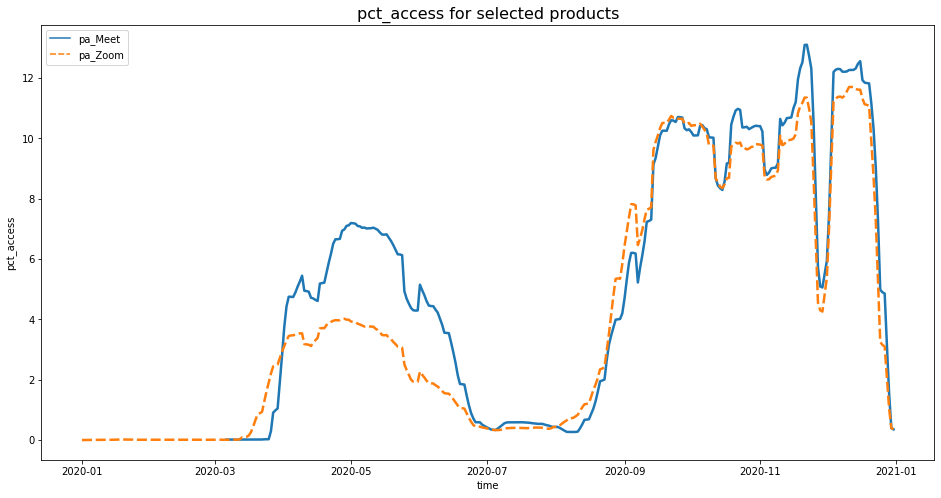

In [109]:
#pct_access per products:
products_pa('Meet', 'Zoom')

In [107]:
#@title Create function to plot engagement_index for products:

def products_ei(*args):  # pass a number of products you want
  
  # Create an empty df:
  tot_df = product_engagement_index_df[product_engagement_index_df.index.get_level_values('Product Name') == 'Google Classroom']['engagement_index'].rolling(7, min_periods=1).mean()
  tot_df = tot_df.to_frame()
  tot_df = tot_df.droplevel('Product Name', axis=0)
  tot_df.drop(['engagement_index'], axis=1, inplace=True)

  for prod in args:
    # Extract engagement_index from the original dataframe:
    ei_df = product_engagement_index_df[product_engagement_index_df.index.get_level_values('Product Name') == str(prod)]['engagement_index'].rolling(7, min_periods=1).mean()
    ei_df = ei_df.to_frame()
    ei_df = ei_df.droplevel('Product Name', axis=0)
    ei_df.rename(columns={"engagement_index": "ei_"+str(prod)}, inplace=True)

    # Concat to the tot_df
    tot_df = pd.concat([tot_df, ei_df], axis=1)

  # Outside the for loop:
  tot_df.index = pd.to_datetime(tot_df.index)

  # Plot the chart:
  fig, ax = plt.subplots(figsize=(16,8))
  sns.lineplot(data=tot_df, palette='tab10', linewidth=2.5)
  ax.set_title("engagement_index for selected products", size=16)
  ax.set_ylabel('engagement_index')



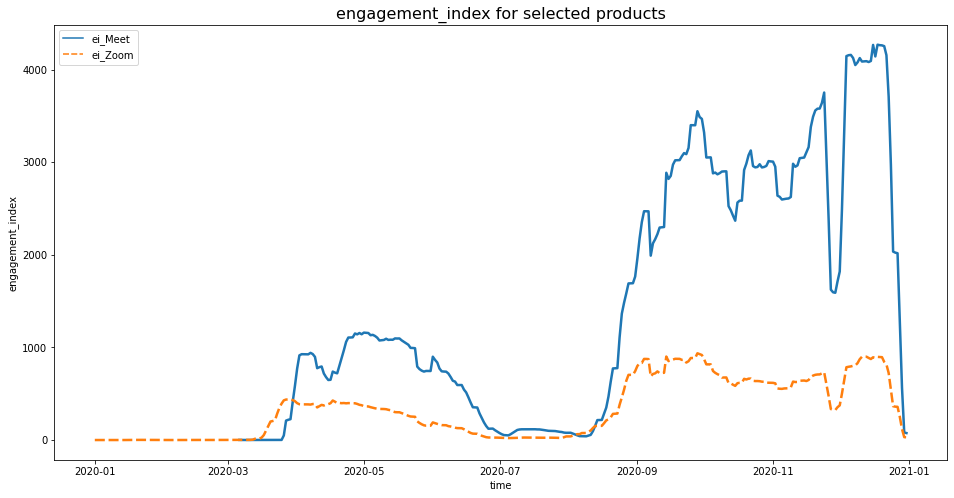

In [110]:
products_ei('Meet', 'Zoom')

Here we did some interesting confrontation between Google Meet and Zoom (both video-communication service). We can see that for the pct_access they are practically the same (an equivalent percentage of students use one or another). However **for engagement_index Google Meet beats definitely Zoom** (Meet has a lot more page-load events than Zoom). Notice the big spike starting in late august of Google Meet, a very impressive growth.

We can guess that Zoom is probably more common for business usage among adults, while Google Meet is more common for students (at least for those in our database).

These charts are very useful to make quick comparison among two or more competing products. 